## Evaluation of Models on Incident Prediction

In [1]:
import numpy as np
import torch
import pandas as pd
from torchmetrics import Accuracy
# from torchmetrics.functional import precision_recall
from tqdm import tqdm
from datetime import datetime as dt
from datetime import time
from matplotlib import pyplot as plt
from copy import deepcopy
from torch.utils.data import DataLoader, Dataset, Subset
from train import create_parser
from models import *
import matplotlib.dates as mdates
from datetime import timedelta
from matplotlib.dates import DateFormatter


c:\Users\haowu\Anaconda3\envs\traffic\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\haowu\Anaconda3\envs\traffic\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


# 0. Load Args

In [49]:
parser = create_parser()
args = parser.parse_args(args=[])
# For reproducibility
seed_torch(args.seed)
args.task = "LR"
args.device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

In [50]:
args.task = "LR"
args.device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')


In [4]:
args 

Namespace(model_type=None, dim_hidden=64, teacher_forcing_ratio=0.5, dropout_prob=0.2, dropout_rec=0.2, dropout_nonrec=0.35, dropout_finetune=0.1, num_layer_GRU=2, num_head=8, num_layer_EncTrans=2, num_layer_DecTrans=2, num_STBlock=1, seq_len_in=7, seq_len_out=6, freq_out=5, LR_threshold=0.5, inc_threshold=0.5, LR_pos_weight=100, nonrec_spd_weight=15, use_expectation=False, use_gt_inc=0, training_granularity=1, time_series_cv_ratio=1, data_train_ratio=0.7, data_val_ratio=0.2, seed=3407, dim_in=0, dim_out=1, num_node=207, use_spd_all=True, use_spd_truck=False, use_spd_pv=False, use_slowdown_spd=True, use_tti=True, use_HA=False, use_dens=False, use_weather=False, use_time=False, use_waze=True, county='TSMO', link_id='110+04483', number_of_point_per_day=186, number_of_business_day=260, upstream_range_mile=2, downstream_range_mile=1, inc_ahead_label_min=0, task='LR', num_epochs=901, batch_size=64, num_workers=0, lr=0.00025, lr_rec=0.00025, lr_nonrec=0.00025, lr_finetune=0.00025, exp_name=N

In [5]:
torch.cuda.is_available() # Check if GPU is used

True

# 1. Load Model and Data

In [6]:
class TrafficData(Dataset):
    """
    Load data under folders
    """
    def __init__(self, args):
        self.args = args     
        if args.model_type == "GTrans":
            X_path = f'{args.data_dir}/model/link_in_out/{args.county}/GTrans_{args.link_id}_{float("{:.1f}".format(args.upstream_range_mile))}_{float("{:.1f}".format(args.downstream_range_mile))}_{args.seq_len_in}_{args.seq_len_out}_{str(args.use_spd_all)[0]}_{str(args.use_spd_truck)[0]}_{str(args.use_spd_pv)[0]}_{str(args.use_slowdown_spd)[0]}_{str(args.use_tti)[0]}_{str(args.use_HA)[0]}_{str(args.use_dens)[0]}_{str(args.use_weather)[0]}_{str(args.use_time)[0]}_{str(args.use_waze)[0]}_{args.inc_ahead_label_min}_x.npy'
            Y_path = f'{args.data_dir}/model/link_in_out/{args.county}/GTrans_{args.link_id}_{float("{:.1f}".format(args.upstream_range_mile))}_{float("{:.1f}".format(args.downstream_range_mile))}_{args.seq_len_in}_{args.seq_len_out}_{str(args.use_spd_all)[0]}_{str(args.use_spd_truck)[0]}_{str(args.use_spd_pv)[0]}_{str(args.use_slowdown_spd)[0]}_{str(args.use_tti)[0]}_{str(args.use_HA)[0]}_{str(args.use_dens)[0]}_{str(args.use_weather)[0]}_{str(args.use_time)[0]}_{str(args.use_waze)[0]}_{args.inc_ahead_label_min}_y.npy' 
        else:
            X_path = f'{args.data_dir}/model/link_in_out/{args.county}/{args.link_id}_{float("{:.1f}".format(args.upstream_range_mile))}_{float("{:.1f}".format(args.downstream_range_mile))}_{args.seq_len_in}_{args.seq_len_out}_{str(args.use_spd_all)[0]}_{str(args.use_spd_truck)[0]}_{str(args.use_spd_pv)[0]}_{str(args.use_slowdown_spd)[0]}_{str(args.use_tti)[0]}_{str(args.use_HA)[0]}_{str(args.use_dens)[0]}_{str(args.use_weather)[0]}_{str(args.use_time)[0]}_{str(args.use_waze)[0]}_{args.inc_ahead_label_min}_x.npy'
            Y_path = f'{args.data_dir}/model/link_in_out/{args.county}/{args.link_id}_{float("{:.1f}".format(args.upstream_range_mile))}_{float("{:.1f}".format(args.downstream_range_mile))}_{args.seq_len_in}_{args.seq_len_out}_{str(args.use_spd_all)[0]}_{str(args.use_spd_truck)[0]}_{str(args.use_spd_pv)[0]}_{str(args.use_slowdown_spd)[0]}_{str(args.use_tti)[0]}_{str(args.use_HA)[0]}_{str(args.use_dens)[0]}_{str(args.use_weather)[0]}_{str(args.use_time)[0]}_{str(args.use_waze)[0]}_{args.inc_ahead_label_min}_y.npy' 

        self.X = torch.from_numpy(np.load(X_path)).float()  
        self.Y = torch.from_numpy(np.load(Y_path)).float()


    def __len__(self):
        samples_per_day = self.args.number_of_point_per_day - self.args.seq_len_out - self.args.seq_len_in + 1
        return int(samples_per_day*self.args.number_of_business_day)

    def __getitem__(self, idx):

        number_of_points_can_be_x_perday = int(self.args.number_of_point_per_day-self.args.seq_len_out)
        number_of_points_can_be_y_perday = int(self.args.number_of_point_per_day-self.args.seq_len_in+1)
        samples_per_day = int(self.args.number_of_point_per_day - self.args.seq_len_out - self.args.seq_len_in + 1)
        day_id = idx // samples_per_day
        time_id = idx % samples_per_day
        X_idx = [day_id*number_of_points_can_be_x_perday+time_id + i for i in range(self.args.seq_len_in)]
        Y_idx = [day_id*number_of_points_can_be_y_perday+time_id + i for i in range(self.args.seq_len_out+1)]  # be careful, the starting point (first idx) of Y is the same as the last idx of X, and won't count into output sequence length
        if args.model_type == "GTrans":
            X = self.X[X_idx, :, :]
        else:
            X = self.X[X_idx, :]   
        Y = self.Y[Y_idx, :, :]

        return X, Y

In [7]:
class FilteredNormalData(Dataset):
    def __init__(self, dataset):
        # only keep data that satisfies sum(Y[:, :, 2]) == 0 and sum(Y[:, :, 3]) == 0
        self.filtered_data = [(x, y) for x, y in dataset if sum(y[:, :, 2]) == 0 and sum(y[:, :, 3]) == 0]

    def __len__(self):
        return len(self.filtered_data)

    def __getitem__(self, idx):
        return self.filtered_data[idx]

In [8]:
def load_data(args):

    torch.manual_seed(args.seed)
    whole_dataset = TrafficData(args=args)

    if args.model_type == "GTrans":
        # load adjency matrix
        upstream_range_mile = float("{:.1f}".format(args.upstream_range_mile))
        downstream_range_mile = float("{:.1f}".format(args.downstream_range_mile))
        adj_matrix_path = f'{args.data_dir}/model/GTrans_adj_matrix/{args.county}/{args.link_id}_{upstream_range_mile}_{downstream_range_mile}_adj.npy'
        adj_matrix = np.load(adj_matrix_path)

    samples_per_day = args.number_of_point_per_day - args.seq_len_out - args.seq_len_in + 1
    train_day_number = int(np.ceil(args.data_train_ratio * int(args.number_of_business_day*args.time_series_cv_ratio)))
    val_day_number = int(np.ceil(args.data_val_ratio * int(args.number_of_business_day*args.time_series_cv_ratio)))
    total_day_number = int(args.number_of_business_day*args.time_series_cv_ratio)
    day_indicies = list(range(0, int(args.number_of_business_day))) # torch.randperm(int(len(whole_dataset)/180)).tolist()
    train_day_indices = day_indicies[:train_day_number]
    val_day_indices = day_indicies[train_day_number:train_day_number+val_day_number]
    test_day_indices = day_indicies[train_day_number+val_day_number:total_day_number]

    train_indices = []
    val_indices = []
    test_indices = []

    for day_number in train_day_indices:
        single_day_indicies = [day_number*samples_per_day +time_point for time_point in range(samples_per_day)]
        selected_single_day_indicies = single_day_indicies[:len(single_day_indicies):args.training_granularity] # reduce the overfitting of highly-overlapped data
        train_indices.extend(selected_single_day_indicies)
  
    for day_number in val_day_indices:
        single_day_indicies = [day_number*samples_per_day +time_point for time_point in range(samples_per_day)]
        val_indices.extend(single_day_indicies)

    for day_number in test_day_indices:
        single_day_indicies = [day_number*samples_per_day +time_point for time_point in range(samples_per_day)]
        test_indices.extend(single_day_indicies)

    train_dataset = torch.utils.data.Subset(whole_dataset, train_indices)
    val_dataset = torch.utils.data.Subset(whole_dataset, val_indices)
    test_dataset = torch.utils.data.Subset(whole_dataset, test_indices)
    
    # to compute FAR
    gan_neg_test_dataset = FilteredNormalData(test_dataset)
    # neg_test_sampled_indices = random.sample(range(len(gan_neg_test_dataset)), len(gan_pos_test_dataset))
    # gan_neg_test_dataset_sampled = torch.utils.data.Subset(gan_neg_test_dataset, neg_test_sampled_indices)
    neg_test_dataloader = DataLoader(dataset=gan_neg_test_dataset, batch_size=args.batch_size, num_workers=args.num_workers, worker_init_fn=seed_worker)

    train_X_list, train_Y_list = zip(*[train_dataset[i] for i in range(len(train_dataset))])
    train_X_tensor = torch.stack(train_X_list)
    train_Y_tensor = torch.stack(train_Y_list)

    val_X_list, val_Y_list = zip(*[val_dataset[i] for i in range(len(val_dataset))])
    val_X_tensor = torch.stack(val_X_list)
    val_Y_tensor = torch.stack(val_Y_list)

    test_X_list, test_Y_list = zip(*[test_dataset[i] for i in range(len(test_dataset))])
    test_X_tensor = torch.stack(test_X_list)
    test_Y_tensor = torch.stack(test_Y_list)


    # read input model dim
    input_dim = test_X_tensor.size(-1)

    train_dloader = DataLoader(dataset=train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=args.num_workers, worker_init_fn=seed_worker)
    val_dloader = DataLoader(dataset=val_dataset, batch_size=args.batch_size, num_workers=args.num_workers, worker_init_fn=seed_worker)
    test_dloader = DataLoader(dataset=test_dataset, batch_size=args.batch_size, num_workers=args.num_workers, worker_init_fn=seed_worker)
    # read imbalanced info
    inc_number = 0
    total_number = 0
    for _, (_, target) in enumerate(train_dloader):
        inc_number += int(target[:, :, :, 3].sum())
        total_number += target[:, :, :, 3].numel()
    imbalnaced_ratio = (total_number-inc_number)/inc_number

    if args.model_type == "GTrans":
        return train_X_tensor, train_Y_tensor, train_dloader, val_X_tensor, val_Y_tensor, val_dloader, test_X_tensor, test_Y_tensor, test_dloader, input_dim, imbalnaced_ratio, neg_test_dataloader, adj_matrix
    else:
        return train_X_tensor, train_Y_tensor, train_dloader, val_X_tensor, val_Y_tensor, val_dloader, test_X_tensor, test_Y_tensor, test_dloader, input_dim, imbalnaced_ratio, neg_test_dataloader, []

In [9]:
def load_model(args):

    if args.model_type=='Seq2Seq':
        traffic_model = Seq2SeqFact(args).to(args.device)
    elif args.model_type=='Trans': # be Trans
        traffic_model = TransFact(args).to(args.device)
    else:
        traffic_model = GTransFact(args).to(args.device)

    args.exp_name = args.model_type

    if args.model_type == 'Seq2Seq':
        args.exp_name += f"_G{args.num_layer_GRU}"
        args.exp_name += f"_{args.upstream_range_mile}_{args.downstream_range_mile}_{str(args.use_spd_all)[0]}_{str(args.use_spd_truck)[0]}_{str(args.use_spd_pv)[0]}_{str(args.use_slowdown_spd)[0]}_{str(args.use_tti)[0]}_{str(args.use_HA)[0]}_{str(args.use_dens)[0]}_{str(args.use_weather)[0]}_{str(args.use_time)[0]}_{str(args.use_waze)[0]}_in_{args.seq_len_in}_out_{args.seq_len_out}_tg_{args.training_granularity}_cv_{args.time_series_cv_ratio}_dp_{args.dropout_prob}_hidden_{args.dim_hidden}_batch_{args.batch_size}_lr_{args.lr}_tf_{args.teacher_forcing_ratio}" 
    else: # for Transformer and G-Transformer
        args.exp_name += f"_H{args.num_head}_E{args.num_layer_EncTrans}_D{args.num_layer_DecTrans}"
        args.exp_name += f"_{args.upstream_range_mile}_{args.downstream_range_mile}_{str(args.use_spd_all)[0]}_{str(args.use_spd_truck)[0]}_{str(args.use_spd_pv)[0]}_{str(args.use_slowdown_spd)[0]}_{str(args.use_tti)[0]}_{str(args.use_HA)[0]}_{str(args.use_dens)[0]}_{str(args.use_weather)[0]}_{str(args.use_time)[0]}_{str(args.use_waze)[0]}_in_{args.seq_len_in}_out_{args.seq_len_out}_tg_{args.training_granularity}_cv_{args.time_series_cv_ratio}_dp_{args.dropout_prob}_hidden_{args.dim_hidden}_batch_{args.batch_size}_lr_{args.lr}_tf_{args.teacher_forcing_ratio}" 

    if args.inc_ahead_label_min > 0:
        args.exp_name += f"_inca_{str(args.inc_ahead_label_min)}"
    
    print(args.exp_name)

    traffic_model_path = "/".join(args.data_dir.split("/"))+"/model"+"/".join(args.checkpoint_dir[1:].split("/"))+"/"+"/".join(args.county.split("/")) +"/"+ "/".join(args.link_id.split("/")) +"/LR/best_{}.pt".format("_".join(args.exp_name.split("_")))
    
    print('model path is', traffic_model_path)
    with open(traffic_model_path, "rb") as f_traffic_model:
        state_dict_traffic = torch.load(f_traffic_model, map_location=args.device)["model"]
        traffic_model.load_state_dict(state_dict_traffic, strict=True)
    print("*****************************model successfully loaded*****************************")
    return traffic_model

In [10]:
def LR_eval(eval_dataloader, model, args):
    
    model.eval() # deactivate dropout, and adjust for batch normalization
    num_sample = 0
    epoch_loss = [0.0]
    traffic_inc_pred_test = []

    for _, batch in enumerate(eval_dataloader):

        x, target = batch
        x = x.to(args.device)  # (batch_size, in_seq_len, dim_in)
        target = target.to(args.device)  # (batch_size, out_seq_len + 1, dim_out, 2) for TrafficModel, (batch_size, out_seq_len + 1, dim_out) for TrafficSeq2Seq

        with torch.no_grad():
            pred, _, _ = model(x, target, mode="eval")
            traffic_inc_pred_test.append(pred)
            # Compute Loss
            criterion_inc = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(args.LR_pos_weight)) # combine nn.Sigmoid() with nn.BCELoss() but more numerically stable; don't forget to set pos_weight 
            loss_per_sample = [criterion_inc(pred, target[:, 1:, :, 3])]  # avg loss per time step per sample
            epoch_loss = [epoch_loss[i] + loss_per_sample[i].detach()*x.size(0)  for i in range(len(epoch_loss))]
            num_sample += x.size(0)

    avg_epoch_loss = [e/num_sample for e in epoch_loss]
    
    traffic_inc_pred_test = torch.cat(traffic_inc_pred_test, dim=0)
 
    return avg_epoch_loss, torch.sigmoid(traffic_inc_pred_test)

# 2. Function Module used for the Incident Evaluation Function

In [11]:
def recall_accuracy_percision_single(pred, truth, threshold):

    truth = np.array(truth)
    mask = np.array(pred)>=threshold
    mask = mask.astype(int)
    TP_mask = mask+truth == 2
    FP_mask = mask-truth == 1
    FN_mask = truth-mask == 1
    TN_mask = truth+mask == 0
    TP_mask = TP_mask.astype(int)
    FP_mask = FP_mask.astype(int)
    FN_mask = FN_mask.astype(int)
    TN_mask = TN_mask.astype(int)
    recall = np.sum(TP_mask)/(np.sum(TP_mask)+np.sum(FN_mask))
    accuracy = (np.sum(TP_mask)+np.sum(TN_mask))/(np.sum(TP_mask)+np.sum(TN_mask)+np.sum(FP_mask)+np.sum(FN_mask))
    percision = np.sum(TP_mask)/(np.sum(TP_mask)+np.sum(FP_mask))
    F1_score = 2*((percision*recall)/(percision+recall))
    
    return recall, accuracy, percision, F1_score

In [12]:
def find_LR_threshold(pred, truth): # F1 eval
    
    thresholds = []
    for i in range(0, 1001):
        threshold = round(i * 0.001, 4)
        thresholds.append(threshold)
    best_F1 = 0
    best_threshold = 0
    for threshold in thresholds:
        threshold_specific_F1 = recall_accuracy_percision_single(pred, truth, threshold)[-1] # F1 score is the last value in that function
        if threshold_specific_F1>best_F1:
            best_F1 = threshold_specific_F1
            best_threshold = threshold

    return best_F1, best_threshold

In [13]:
def faltten_inc_ground_truth(input_array, day_number, day_point_number):
    # print(input_array.shape[0], day_number, day_point_number)
    
    assert input_array.shape[0] == day_number* day_point_number, 'check input shape in function faltten_inc_ground_truth'
    flatten_list = []

    for i in range(day_number):
        day_flatten_list = input_array[i*day_point_number, :, :].numpy()

        for j in range(1, day_point_number):
            day_flatten_list = np.append(day_flatten_list, input_array[i*day_point_number+j, -1, :].numpy())
            
        flatten_list = np.append(flatten_list, day_flatten_list)

    return flatten_list

In [14]:
def faltten_pred_result(input_array, day_number, day_point_number, type, threshold):
    print(input_array.shape[0], day_number, day_point_number)

    assert input_array.shape[0] == day_number* day_point_number, 'check input shape in function  faltten_pred_result'
    
    all_pred_list = []

    for i in range(day_number):
        day_pred_list = []
        for j in range(day_point_number):
            if type=='min':
                single_step_pred_result = 1 if min(input_array[i*day_point_number+j, :, :].numpy())>=threshold else 0
            elif type=='max':
                single_step_pred_result = 1 if max(input_array[i*day_point_number+j, :, :].numpy())>=threshold else 0
            elif type=='avg':
                single_step_pred_result = 1 if np.mean(input_array[i*day_point_number+j, :, :].numpy())>=threshold else 0
            day_pred_list.append(single_step_pred_result)
        all_pred_list.append(day_pred_list)
     
    return all_pred_list

In [15]:
def filter_Waze(waze_raw, ground_truth):
    # This function is used to filter those waze incident labelled as influential
    # i.e., find waze reports that have intersection with our ground truth

    filtered_Waze = np.zeros_like(waze_raw)
 
    # Find the start and end indices of consecutive ones in waze_raw
    ones_indices = np.where(np.diff(waze_raw, prepend=0, append=0) == 1)[0]

    # Iterate over each consecutive group of ones
    for start in ones_indices:
        # Find the end of the current group
        end = np.where(waze_raw[start:] == 0)[0]
        end = end[0] + start if end.size > 0 else waze_raw.size
        # If any of the corresponding values in ground_truth are 1, set all values in filtered_Waze to 1
        if np.any(ground_truth[start:end] == 1):
            filtered_Waze[start:end] = 1
            
    return list(filtered_Waze)

In [16]:
# this match fucntion is based on E.S.T., edit as you need
def find_correspond_waze_report(args, inc_start_point, inc_date_number, model_path, start_date, end_date, start_time):
    
    # get raw waze reports
    raw_waze =   pickle.load(open(f"{model_path}/data/{args.county}/processed_data/{args.county}_raw_waze_inc_eval.pkl", "rb"))
    
    # only keep the waze reports happened on that link
    link_specific_waze = raw_waze[raw_waze.id_tmc == args.link_id]
    
    # only keep the waze reports happened on that date
    link_specific_waze['Start time'] = pd.to_datetime(link_specific_waze['Start time'], errors='coerce', utc=True).dt.tz_convert('America/New_York')
    link_specific_waze['Closed time'] = pd.to_datetime(link_specific_waze['Closed time'], errors='coerce', utc=True).dt.tz_convert('America/New_York')
    link_specific_waze['Start Date'] = link_specific_waze['Start time'].dt.date.astype(str)
    link_specific_waze['Closed Date'] = link_specific_waze['Closed time'].dt.date.astype(str)
    busi_date = pd.bdate_range(start=start_date, end=end_date).date 
    inc_date = busi_date[inc_date_number].strftime('%Y-%m-%d')
    link_day_specific_waze = link_specific_waze[(link_specific_waze['Start Date']  == inc_date) & (link_specific_waze['Closed Date']  == inc_date)]
    print('inc_date is', inc_date_number, inc_date)
    # print(link_day_specific_waze)
    # find the time where we start to label
    # label_start_time = start_time+(inc_start_point+args.seq_len_in)*args.freq_out # in minute format, for example, if 120 means 2:00 a.m.
    # label_start_hour = int(label_start_time/60)
    # label_start_minute = int(label_start_time % 60)
    # label_start = dt.combine(busi_date[inc_date_number], time(label_start_hour, label_start_minute))

    
    print('waze/ filtered waze info in the day in the link is')
    print(link_day_specific_waze[['System', 'Agency', 'Standardized Type', 'Agency-specific Type']]) # , 'Agency-specific Sub Type'
    print(link_day_specific_waze[['Start time', 'Closed time']])
    print(link_day_specific_waze[['Latitude', 'Longitude']])

In [17]:
def check_link_time_speed(args, day_id, start_id, end_id):
    # 0 for 5:30
    print('day_id', day_id, 'start_id', start_id, 'end_id', end_id)
    df_spd =   pickle.load(open(f"{args.model_path}/data/{args.county}/processed_data/{args.county}_df_spd_tmc_5min_all_from_1_min.pkl", "rb"))
    
    df_spd = df_spd[args.link_id]
    print('speed', list(df_spd.iloc[day_id*args.number_of_point_per_day+start_id:day_id*args.number_of_point_per_day+end_id]))
    df_sd_spd = pickle.load(open(f"{args.model_path}/data/{args.county}/processed_data/{args.county}_slowdown_speed.pkl", "rb"))
    df_sd_spd = df_sd_spd[args.link_id]
    print('slowdown speed',list(df_sd_spd.iloc[day_id*args.number_of_point_per_day+start_id:day_id*args.number_of_point_per_day+end_id]))
    print(df_spd.iloc[day_id*args.number_of_point_per_day+start_id:day_id*args.number_of_point_per_day+end_id])

In [18]:
def check_correspond_date_alert(args, check_day_number, prediction_indices):
    
    start_indices = np.where(np.diff(prediction_indices, prepend=0, append=0) == 1)[0]

    busi_date = pd.bdate_range(start=args.start_date, end=args.end_date).date 
    check_date = busi_date[check_day_number].strftime('%Y-%m-%d')
    
    if start_indices.size == 0:
        print(f'No Alert in {check_date}')
    else:
        for start_id in start_indices:
            report_start_time = args.start_time+(start_id+args.seq_len_in-1)*args.freq_out
            report_start_hour = int(report_start_time/60)
            report_start_minute = int(report_start_time % 60)
            report_start = dt.combine(busi_date[check_day_number], time(report_start_hour, report_start_minute))

            print('&'*35)

            print(f'Alert Starts At {report_start}')

            first_zero = np.where(prediction_indices[start_id:]== 0)[0]
            if first_zero.size >0:
                end_id = first_zero[0] + start_id
                report_end_time = args.start_time+(end_id+args.seq_len_in-1)*args.freq_out
                report_end_hour = int(report_end_time/60)
                report_end_minute = int(report_end_time % 60)
                report_end = dt.combine(busi_date[check_day_number], time(report_end_hour, report_end_minute))
                print(f'No Alert At {report_end}')
                check_link_time_speed(args, check_day_number, args.seq_len_in-1+start_id, min(args.seq_len_in-1+end_id+8, args.number_of_point_per_day))
            print('&'*35)


In [19]:
def check_our_report(args, inc_start_point, inc_date_number, model_path, start_date, end_date, start_time, prediction_indices):
    
    # get raw waze reports
    raw_waze =   pickle.load(open(f"{model_path}/data/{args.county}/processed_data/{args.county}_raw_waze_inc_eval.pkl", "rb"))
    
    # only keep the waze reports happened on that link
    link_specific_waze = raw_waze[raw_waze.id_tmc == args.link_id]
    
    # only keep the waze reports happened on that date
    link_specific_waze['Start time'] = pd.to_datetime(link_specific_waze['Start time'], errors='coerce', utc=True).dt.tz_convert('America/New_York')
    link_specific_waze['Closed time'] = pd.to_datetime(link_specific_waze['Closed time'], errors='coerce', utc=True).dt.tz_convert('America/New_York')
    link_specific_waze['Start Date'] = link_specific_waze['Start time'].dt.date.astype(str)
    link_specific_waze['Closed Date'] = link_specific_waze['Closed time'].dt.date.astype(str)
    busi_date = pd.bdate_range(start=start_date, end=end_date).date 
    inc_date = busi_date[inc_date_number].strftime('%Y-%m-%d')
    link_day_specific_waze = link_specific_waze[(link_specific_waze['Start Date']  == inc_date) & (link_specific_waze['Closed Date']  == inc_date)]
    
    # find the time where we start to label
    label_start_time = start_time+(inc_start_point+args.seq_len_in)*args.freq_out # in minute format, for example, if 120 means 2:00 a.m.
    label_start_hour = int(label_start_time/60)
    label_start_minute = int(label_start_time % 60)
    label_start = dt.combine(busi_date[inc_date_number], time(label_start_hour, label_start_minute))

    
    # print('waze/ filtered waze info in the day in the link is')
    # print(link_day_specific_waze[['System', 'Agency', 'Standardized Type', 'Agency-specific Type']]) # , 'Agency-specific Sub Type'
    # print(link_day_specific_waze[['Start time', 'Closed time']])
    # print(link_day_specific_waze[['Latitude', 'Longitude']])


    index_of_first_one = len(list(prediction_indices)) - list(prediction_indices).index(1) - 1
    report_start_time = label_start_time - index_of_first_one*args.freq_out
    report_start_hour = int(report_start_time/60)
    report_start_minute = int(report_start_time % 60)
    report_start = dt.combine(busi_date[inc_date_number], time(report_start_hour, report_start_minute))
    print('we start to report at ', report_start)

In [20]:
def compare_waze_with_pred(args, zero_day_number, waze_array, ground_turth_array, pred_array, day_number, ahead_check, output_length, use_filtered_Waze = True):
    # zero_day_number: if we consider the whole data set, the day_number first day in the waze_array, for comparsion with waze
    # ahead_number: How many time steps (how many 5 minutes, if the granularity is 5) earlier than the incident is considered a true forecast, and any earlier than that is considered a false alarm
    # use_filtered_Waze: if true, only consider the filtered waze (the influential Waze reports), otherwise, consider all Waze reports
    

    filtered_Waze_array = []
    for i in range(day_number):
        filtered_day_waze = filter_Waze(waze_array[i,:], ground_turth_array[i, :])
        filtered_Waze_array.append(filtered_day_waze)
    filtered_Waze_array = np.array(filtered_Waze_array)
    
    total_incident_number = 0
    early_deteced_incident_number = 0
    not_late_deteced_incident_number = 0
    # output_length
    # ahead_prediction_time = 0

    for j in range(day_number):
        
        day_prediction = pred_array[j, :]
        
        if use_filtered_Waze:
            day_ground_truth = filtered_Waze_array[j, :]
        else:
            day_ground_truth = waze_array[j, :]
        
        # currently, we only focus on incident before 20:30, that is why we set [:-output_length]
        start_indices = np.where(np.diff(day_ground_truth[:-output_length], prepend=0, append=0) == 1)[0]
        
        total_incident_number += len(start_indices)
        for start in start_indices:
            print('*'*60)

            find_correspond_waze_report(
                args, start, zero_day_number+j, args.model_path, 
                args.start_date, args.end_date, args.start_time,# not changed with day number, start_time means the time we started to collect data
            )

            check_correspond_date_alert(args, zero_day_number+j, day_prediction)

            if start<len(day_prediction): 
                if sum(day_prediction[max(start+2-ahead_check, 0):start+2])>=1:
                    # the id in ground_truth is one step later than the prediction
                    # for example, id = 0 in start indices refers to the incident status 6:05
                    # while id = 0 in prediction indices refers to the prediction made at 6:00
                    # another example, if there is an incident with start id is 7
                    # then it refers to the incident happened at 6:40, or more orecisely, happened between 6:40-6:45, (see incident labelling rule in generate_raw_inc_data.ipynb) 
                    # if we can predict the incident in either 6:20, 6:25, 6:30, 6:35, 6:40 (assume the ahead_number is 5)
                    # then it will be regarded as an early detection. 
                    # 6:40's id in the prediction is 8 (noted the prediction starts at 6:00), thus we use start+2 in the above line of code
                    early_deteced_incident_number +=1
                    print('***************************************************************************')
                    pred_indices = day_prediction[max(start-ahead_check-10, 0):start+2]
                    print(j, pred_indices, 'start_indice', start_indices)
                    
                    
                    check_our_report(
                        args, start, zero_day_number+j, args.model_path, 
                        args.start_date, args.end_date, args.start_time,# not changed with day number, start_time means the time we started to collect data
                        pred_indices
                        ) 
                    
                if sum(day_prediction[max(start+2-ahead_check, 0):start+3])>=1:
                    # Based on the same example as abpve, if there is an incident happened between 6:40-6:45, 
                    # and we can predict the incident in either 6:20, 6:25, 6:30, 6:35, 6:40, and 6:45
                    # then it will be regarded as a not_late_deteced_incident
                    not_late_deteced_incident_number += 1

                    
                    
    print('total incident number is', total_incident_number)
    print('early_deteced_incident_number is', early_deteced_incident_number)
    print('not_late_deteced_incident_number is', not_late_deteced_incident_number)

# 3. Incident Evaluation Function

In [21]:
prediction_start_time = dt.strptime('06:00', '%H:%M')
interval = timedelta(minutes=5)

In [22]:
def check_total_false_negative(input_array, type, threshold):

    pred_array = np.squeeze(input_array, axis=-1).numpy()
    if type == 'min':
        min_values = np.amin(pred_array, axis=1)
        false_negatives = (min_values > threshold).astype(int)
    elif type == 'max':
        max_values = np.amax(pred_array, axis=1)
        false_negatives = (max_values > threshold).astype(int)
    elif type == 'avg':
        avg_values = np.mean(pred_array, axis=1)
        false_negatives = (avg_values > threshold).astype(int)
    else:
        raise ValueError("Type must be 'min', 'max', or 'avg'")
    print(np.shape(false_negatives))

    return np.sum(false_negatives)

In [23]:
class IncidentDetectionAnalysis_:
    
    def __init__(self, 
            args,
            prediciotn_array, 
            annomaly_array,
            interval =  timedelta(minutes=5), 
            prediction_start_time = '06:00',
        ):
        self.link_id = args.link_id # tmc id link
        self.interval = interval # every 5 minute
        self.prediction_start_time = prediction_start_time # 6:00 a.m., str
        self.prediction_array = prediciotn_array # model output, flattened, [number_of_days, 174]
        self.annomaly_array = annomaly_array # denoised incident label, falttened, [number_of_days, 17?]
        
        df_waze = pd.read_pickle(f"{args.data_dir}/data/{args.county}/processed_data/{args.county}_raw_waze_inc_eval.pkl")

        df_waze_link = df_waze[df_waze.id_tmc == self.link_id]
        df_waze_link['Start time'] = pd.to_datetime(df_waze_link['Start time'], errors='coerce')
        df_waze_link['Closed time'] = pd.to_datetime(df_waze_link['Closed time'], errors='coerce')
        try:
            df_waze_link['Start time'] = df_waze_link['Start time'].apply(lambda x: x.tz_localize(None))
            df_waze_link['Closed time'] = df_waze_link['Closed time'].apply(lambda x: x.tz_localize(None))
        except Exception as e:
            print(f"Error localizing time: {e}")

        self.df_waze_link = df_waze_link

        self.day_n = prediciotn_array.shape[0]
        print('day_number_is', self.day_n)
        busi_date = pd.bdate_range(start=args.start_date, end=args.end_date).date
        self.test_date = busi_date[-self.day_n:]
    
    def _get_time_periods(self, day_array, date_str):
        prediction_start_date_time = dt.strptime(f'{date_str} {self.prediction_start_time}', '%Y-%m-%d %H:%M')
        periods = []
        n = len(day_array)
        i = 0
        while i < n:
            if day_array[i] == 1:
                start_idx = i
                while i < n and day_array[i] == 1:
                    i += 1
                end_idx = i - 1
                start_period = prediction_start_date_time + start_idx * self.interval
                end_period = prediction_start_date_time + (end_idx + 1) * self.interval
                periods.append((start_period, end_period))
            i += 1
        return periods
    
    def _generate_day_incident_periods(self, date_str):
        
        given_date = dt.strptime(date_str, '%Y-%m-%d')
        start_time = given_date.replace(hour=6, minute=0, second=0) # edit as needed
        end_time = given_date.replace(hour=20, minute=25, second=0) # edit as needed
        df_filtered = self.df_waze_link[(self.df_waze_link['Start time'].dt.date == given_date.date()) | (self.df_waze_link['Closed time'].dt.date == given_date.date())]
        incident_periods = []
        
        for _, row in df_filtered.iterrows():
            incident_start = max(row['Start time'], start_time)
            incident_end = min(row['Closed time'], end_time)
            if incident_start < incident_end:
                incident_periods.append((incident_start, incident_end))
        
        if not incident_periods:
            return []
        
        incident_periods.sort()
        merged_periods = []
        current_start, current_end = incident_periods[0]
        for start, end in incident_periods[1:]:
            if start <= current_end:
                current_end = max(current_end, end)
            else:
                merged_periods.append((current_start, current_end))
                current_start, current_end = start, end
        
        merged_periods.append((current_start, current_end))
        merged_periods = [(pd.Timestamp(start).to_pydatetime(), pd.Timestamp(end).to_pydatetime()) for start, end in merged_periods]
        return merged_periods
    
    def _is_overlap(self, period1, period2):
        return period1[0] < period2[1] and period1[1] > period2[0]
    
    
    def _check_far_fp(self,  report_period, alert_period):
        alert_number = len(alert_period)
        false_postive_case = []
        false_alert_number = 0
        for alert in alert_period:
            true_alert = False
            for report in report_period:
                if self._is_overlap(alert, report):
                    true_alert = True
            if not true_alert:
                false_alert_number += 1
                false_postive_case.append(alert)
        return alert_number, false_alert_number, false_postive_case
    

    def _check_sfar_sfp(self, report_period, alert_period, annomaly_period):
        alert_number = len(alert_period)
        sfalse_postive_case = []
        sfalse_alert_number = 0
        for alert in alert_period:
            true_alert = False
            for report in report_period:
                if self._is_overlap(alert, report):
                    true_alert = True
            for annomaly in  annomaly_period:
                if self._is_overlap(alert, annomaly):
                    true_alert = True
            if not true_alert:
                sfalse_alert_number += 1
                sfalse_postive_case.append(alert)
        return alert_number, sfalse_alert_number, sfalse_postive_case
    
    def _check_dr_mttd_fn(self, report_period, alert_period):
        report_number = len(report_period)
        total_ttd = 0
        detected_number = 0
        fail_to_detect_case = []
        for report in report_period:
            detected = False
            ttd_list = []
            for alert in alert_period:
                if self._is_overlap(alert, report):
                    detected = True
                    time_difference = alert[0] - report[0]
                    time_difference_in_minute = time_difference.total_seconds() / 60
                    ttd_list.append(time_difference_in_minute)
            if detected: 
                ttd = min(ttd_list)
                total_ttd += ttd
                detected_number += 1
            else:
                fail_to_detect_case.append(report)
        return report_number, detected_number, total_ttd, fail_to_detect_case
    
    def _check_sdr_smttd_sfn(self, report_period, alert_period, annomaly_period):
        signficant_report_period = []
        for report in report_period:
            for annomaly in annomaly_period:
                if self._is_overlap(report, annomaly):
                    signficant_report_period.append(report)
                    break 

        s_report_number = len(signficant_report_period)
        s_total_ttd = 0
        s_detected_number = 0
        s_fail_to_detect_case = []
        for report in signficant_report_period:
            detected = False
            ttd_list = []
            for alert in alert_period:
                if self._is_overlap(alert, report):
                    detected = True
                    time_difference = alert[0] - report[0]
                    time_difference_in_minute = time_difference.total_seconds() / 60
                    ttd_list.append(time_difference_in_minute)
            if detected:
                ttd = min(ttd_list)
                s_total_ttd += ttd
                s_detected_number += 1
            else:
                s_fail_to_detect_case.append(report)
        return s_report_number, s_detected_number, s_total_ttd, s_fail_to_detect_case
    
    def check_day_result(self, day_pred_array, date_str):
        day_report_merged_period = self._generate_day_incident_periods(date_str)
        day_alart_period = self._get_time_periods(day_pred_array, date_str)
        day_report_number, day_detected_number, day_total_ttd, day_fail_to_detect_cases = self._check_dr_mttd_fn(day_report_merged_period, day_alart_period)
        day_alert_number, day_false_alert_number, day_false_postive_cases = self._check_far_fp(day_report_merged_period, day_alart_period)
        return day_report_number, day_detected_number, day_total_ttd, day_alert_number, day_false_alert_number, day_fail_to_detect_cases, day_false_postive_cases
    
    def check_day_result_s(self, day_pred_array, day_annomlay_array, date_str):
        day_report_merged_period = self._generate_day_incident_periods(date_str)
        day_alart_period = self._get_time_periods(day_pred_array, date_str)
        day_annom_period = self._get_time_periods(day_annomlay_array, date_str)
        day_report_number, day_detected_number, day_total_ttd, day_fail_to_detect_cases = self._check_sdr_smttd_sfn(day_report_merged_period, day_alart_period, day_annom_period)
        day_alert_number, day_false_alert_number, day_false_postive_cases = self._check_sfar_sfp(day_report_merged_period, day_alart_period, day_annom_period)
        return day_report_number, day_detected_number, day_total_ttd, day_alert_number, day_false_alert_number, day_fail_to_detect_cases, day_false_postive_cases
    
    def check_overall_results(self):
        total_report_number, total_detected_number, total_ttd, total_alert_number, total_false_alert_number = 0, 0, 0, 0, 0
        all_fail_to_detect_cases = []
        all_false_postive_cases = []

        for i in range(len(self.test_date)):
            day_pred_array = self.prediction_array[i]
            date_str = self.test_date[i].strftime("%Y-%m-%d")
            day_report_number, day_detected_number, day_total_ttd, day_alert_number, day_false_alert_number, day_fail_to_detect_cases, day_false_postive_cases= self.check_day_result(day_pred_array, date_str)
            total_report_number += day_report_number
            total_detected_number += day_detected_number
            total_ttd += day_total_ttd 
            total_alert_number += day_alert_number 
            total_false_alert_number += day_false_alert_number
            all_fail_to_detect_cases.extend(day_fail_to_detect_cases)
            all_false_postive_cases.extend(day_false_postive_cases)
        
        if total_report_number != 0:
            DR = total_detected_number/total_report_number
        else:
            DR = 0
        
        if total_detected_number !=0:
            MTTD = total_ttd/total_detected_number
        else:
            MTTD = 0

        if total_alert_number!= 0:
            FAR = total_false_alert_number/total_alert_number
        else:
            FAR = 0
        
        return DR, FAR, MTTD, all_fail_to_detect_cases, all_false_postive_cases
    
    def check_overall_s_results(self):
        total_report_number, total_detected_number, total_ttd, total_alert_number, total_false_alert_number = 0, 0, 0, 0, 0
        all_fail_to_detect_cases = []
        all_false_postive_cases = []

        for i in range(len(self.test_date)):
            day_pred_array = self.prediction_array[i]
            day_anno_array = self.annomaly_array[i]
            date_str = self.test_date[i].strftime("%Y-%m-%d")
            day_report_number, day_detected_number, day_total_ttd, day_alert_number, day_false_alert_number, day_fail_to_detect_cases, day_false_postive_cases= self.check_day_result_s(day_pred_array, day_anno_array, date_str)
            total_report_number += day_report_number
            total_detected_number += day_detected_number
            total_ttd += day_total_ttd 
            total_alert_number += day_alert_number 
            total_false_alert_number += day_false_alert_number
            all_fail_to_detect_cases.extend(day_fail_to_detect_cases)
            all_false_postive_cases.extend(day_false_postive_cases)
        
        if total_report_number != 0:
            DR = total_detected_number/total_report_number
        else:
            DR = 0
        
        if total_detected_number !=0:
            MTTD = total_ttd/total_detected_number
        else:
            MTTD = 0

        if total_alert_number!= 0:
            FAR = total_false_alert_number/total_alert_number
        else:
            FAR = 0
        
        return DR, FAR, MTTD, all_fail_to_detect_cases, all_false_postive_cases

In [24]:
class IncidentDetectionAnalysis:
    
    def __init__(self, 
            args,
            prediciotn_array, 
            annomaly_array,
            interval =  timedelta(minutes=5), 
            prediction_start_time =  '06:00', #'06:05',
        ):
        self.link_id = args.link_id # tmc id link
        self.interval = interval # every 5 minute
        self.prediction_start_time = prediction_start_time # 6:00 a.m., str
        self.prediction_array = prediciotn_array # model output, flattened, [number_of_days, 174]
        self.annomaly_array = annomaly_array # denoised incident label, falttened, [number_of_days, 17?]
        
        df_waze = pd.read_pickle(f"{args.data_dir}/data/{args.county}/processed_data/{args.county}_raw_waze_inc_eval.pkl")

        df_waze_link = df_waze[df_waze.id_tmc == self.link_id]
        df_waze_link['Start time'] = pd.to_datetime(df_waze_link['Start time'], errors='coerce')
        df_waze_link['Closed time'] = pd.to_datetime(df_waze_link['Closed time'], errors='coerce')
        try:
            df_waze_link['Start time'] = df_waze_link['Start time'].apply(lambda x: x.tz_localize(None))
            df_waze_link['Closed time'] = df_waze_link['Closed time'].apply(lambda x: x.tz_localize(None))
        except Exception as e:
            print(f"Error localizing time: {e}")

        self.df_waze_link = df_waze_link

        self.day_n = prediciotn_array.shape[0]
        print('day_number_is', self.day_n)
        busi_date = pd.bdate_range(start=args.start_date, end=args.end_date).date
        self.test_date = busi_date[-self.day_n:]
    
    def _get_time_periods(self, day_array, date_str):
        prediction_start_date_time = dt.strptime(f'{date_str} {self.prediction_start_time}', '%Y-%m-%d %H:%M')
        periods = []
        n = len(day_array)
        i = 0
        while i < n:
            if day_array[i] == 1:
                start_idx = i
                while i < n and day_array[i] == 1:
                    i += 1
                end_idx = i - 1
                start_period = prediction_start_date_time + start_idx * self.interval
                end_period = prediction_start_date_time + (end_idx + 1) * self.interval
                periods.append((start_period, end_period))
            i += 1
        return periods
    
    def _generate_day_incident_periods(self, date_str):
        
        given_date = dt.strptime(date_str, '%Y-%m-%d')
        start_time = given_date.replace(hour=6, minute=0, second=0) # edit as needed
        end_time = given_date.replace(hour=20, minute=25, second=0) # edit as needed
        df_filtered = self.df_waze_link[(self.df_waze_link['Start time'].dt.date == given_date.date()) | (self.df_waze_link['Closed time'].dt.date == given_date.date())]
        incident_periods = []
        
        for _, row in df_filtered.iterrows():
            incident_start = max(row['Start time'], start_time)
            incident_end = min(row['Closed time'], end_time)
            if incident_start < incident_end:
                incident_periods.append((incident_start, incident_end))
        
        if not incident_periods:
            return []
        
        incident_periods.sort()
        merged_periods = []
        current_start, current_end = incident_periods[0]
        for start, end in incident_periods[1:]:
            if start <= current_end:
                current_end = max(current_end, end)
            else:
                merged_periods.append((current_start, current_end))
                current_start, current_end = start, end
        
        merged_periods.append((current_start, current_end))
        merged_periods = [(pd.Timestamp(start).to_pydatetime(), pd.Timestamp(end).to_pydatetime()) for start, end in merged_periods]
        return merged_periods
    
    def _is_overlap(self, period1, period2):
        return period1[0] < period2[1] and period1[1] > period2[0]
    
    
    def _check_far_fp(self,  report_period, alert_period):
        alert_number = len(alert_period)
        false_postive_case = []
        false_alert_number = 0
        for alert in alert_period:
            true_alert = False
            for report in report_period:
                if self._is_overlap(alert, report):
                    true_alert = True
            if not true_alert:
                false_alert_number += 1
                false_postive_case.append(alert)
        return alert_number, false_alert_number, false_postive_case
    

    def _check_sfar_sfp(self, report_period, alert_period, annomaly_period):
        alert_number = len(alert_period)
        sfalse_postive_case = []
        sfalse_alert_number = 0
        for alert in alert_period:
            true_alert = False
            for report in report_period:
                if self._is_overlap(alert, report):
                    true_alert = True
            for annomaly in  annomaly_period:
                if self._is_overlap(alert, annomaly):
                    true_alert = True
            if not true_alert:
                sfalse_alert_number += 1
                sfalse_postive_case.append(alert)
        return alert_number, sfalse_alert_number, sfalse_postive_case
    
    def _check_dr_mttd_fn(self, report_period, alert_period):

        report_number = len(report_period)
        total_ttd = 0
        detected_number = 0
        fail_to_detect_case = []
        
        Detected_Report_Alert_Dict = {} # key, report_id; value, alerts
        Detected_Report_Dict = {}
        
        for report_id in range(len(report_period)):
            report = report_period[report_id]
            detected = False
            ttd_list = []
            for alert in alert_period:
                if self._is_overlap(alert, report):

                    if report_id in Detected_Report_Alert_Dict.keys():
                        Detected_Report_Alert_Dict[report_id].append(alert)
                    else:
                        Detected_Report_Alert_Dict[report_id] = []
                        Detected_Report_Alert_Dict[report_id] = [alert]
                        Detected_Report_Dict[report_id] = []
                        Detected_Report_Dict[report_id] = [report]

                    detected = True
                    time_difference = alert[0] - report[0]
                    time_difference_in_minute = time_difference.total_seconds() / 60
                    ttd_list.append(time_difference_in_minute)
            
            if detected:
                ttd = min(ttd_list)
                print('detected!!!!!!!', ttd_list, ttd)
                total_ttd += ttd
                detected_number += 1

            else:
                fail_to_detect_case.append(report)
        
        if detected_number != len(list(Detected_Report_Dict.keys())):
            raise ValueError('Check _check_dr_mttd_fn Function')

        return report_number, detected_number, total_ttd, fail_to_detect_case, Detected_Report_Dict, Detected_Report_Alert_Dict
    
    def _check_sdr_smttd_sfn(self, report_period, alert_period, annomaly_period):
        signficant_report_period = []
        for report in report_period:
            for annomaly in annomaly_period:
                if self._is_overlap(report, annomaly):
                    signficant_report_period.append(report)
                    break 

        s_report_number = len(signficant_report_period)
        s_total_ttd = 0
        s_detected_number = 0
        s_fail_to_detect_case = []

        Detected_Report_Alert_Dict = {} # key, report_id; value, alerts
        Detected_Report_Dict = {}

        for report_id in range(len(signficant_report_period)):

            report = signficant_report_period[report_id]

            detected = False
            ttd_list = []
            for alert in alert_period:
                if self._is_overlap(alert, report):

                    if report_id in Detected_Report_Alert_Dict.keys():
                        Detected_Report_Alert_Dict[report_id].append(alert)
                    else:
                        Detected_Report_Alert_Dict[report_id] = []
                        Detected_Report_Alert_Dict[report_id] = [alert]
                        Detected_Report_Dict[report_id] = []
                        Detected_Report_Dict[report_id] = [report]

                    detected = True
                    time_difference = alert[0] - report[0]
                    time_difference_in_minute = time_difference.total_seconds() / 60
                    ttd_list.append(time_difference_in_minute)
            if detected:
                ttd = min(ttd_list)
                s_total_ttd += ttd
                s_detected_number += 1
            else:
                s_fail_to_detect_case.append(report)
            
        if s_detected_number != len(list(Detected_Report_Dict.keys())):
            raise ValueError('Check _check_sdr_smttd_sfn Function')
        
        return s_report_number, s_detected_number, s_total_ttd, s_fail_to_detect_case, Detected_Report_Dict, Detected_Report_Alert_Dict
    
    def check_day_result(self, day_pred_array, date_str):
        day_report_merged_period = self._generate_day_incident_periods(date_str)
        day_alart_period = self._get_time_periods(day_pred_array, date_str)
        day_report_number, day_detected_number, day_total_ttd, day_fail_to_detect_cases, Day_Detected_Report_Dict, Day_Detected_Report_Alert_Dict = self._check_dr_mttd_fn(day_report_merged_period, day_alart_period)
        day_alert_number, day_false_alert_number, day_false_postive_cases = self._check_far_fp(day_report_merged_period, day_alart_period)
        return day_report_number, day_detected_number, day_total_ttd, day_alert_number, day_false_alert_number, day_fail_to_detect_cases, day_false_postive_cases, Day_Detected_Report_Dict, Day_Detected_Report_Alert_Dict
    
    def check_day_result_s(self, day_pred_array, day_annomlay_array, date_str):
        day_report_merged_period = self._generate_day_incident_periods(date_str)
        day_alart_period = self._get_time_periods(day_pred_array, date_str)
        day_annom_period = self._get_time_periods(day_annomlay_array, date_str)
        day_report_number, day_detected_number, day_total_ttd, day_fail_to_detect_cases, Day_Detected_Report_Dict, Day_Detected_Report_Alert_Dict = self._check_sdr_smttd_sfn(day_report_merged_period, day_alart_period, day_annom_period)
        day_alert_number, day_false_alert_number, day_false_postive_cases = self._check_sfar_sfp(day_report_merged_period, day_alart_period, day_annom_period)
        return day_report_number, day_detected_number, day_total_ttd, day_alert_number, day_false_alert_number, day_fail_to_detect_cases, day_false_postive_cases, Day_Detected_Report_Dict, Day_Detected_Report_Alert_Dict
    
    def check_overall_results(self):
        total_report_number, total_detected_number, total_ttd, total_alert_number, total_false_alert_number = 0, 0, 0, 0, 0
        all_fail_to_detect_cases = []
        all_false_postive_cases = []

        Detected_Report_Dict = {}
        Detected_Report_Alert_Dict = {}

        for i in range(len(self.test_date)):
            day_pred_array = self.prediction_array[i]
            date_str = self.test_date[i].strftime("%Y-%m-%d")
            day_report_number, day_detected_number, day_total_ttd, day_alert_number, day_false_alert_number, day_fail_to_detect_cases, day_false_postive_cases, Day_Detected_Report_Dict, Day_Detected_Report_Alert_Dict = self.check_day_result(day_pred_array, date_str)
            total_report_number += day_report_number
            total_detected_number += day_detected_number
            total_ttd += day_total_ttd 
            total_alert_number += day_alert_number 
            total_false_alert_number += day_false_alert_number
            all_fail_to_detect_cases.extend(day_fail_to_detect_cases)
            all_false_postive_cases.extend(day_false_postive_cases)

            report_id_list = list(Day_Detected_Report_Dict.keys())

            for j in range(day_detected_number):
                Detected_Report_Dict[total_detected_number-day_detected_number+j] = []
                Detected_Report_Alert_Dict[total_detected_number-day_detected_number+j] = []
                report_id = report_id_list[j]
                Detected_Report_Dict[total_detected_number-day_detected_number+j] = Day_Detected_Report_Dict[report_id]
                Detected_Report_Alert_Dict[total_detected_number-day_detected_number+j] = Day_Detected_Report_Alert_Dict[report_id]
        
        if total_report_number != 0:
            DR = total_detected_number/total_report_number
        else:
            DR = 0
        
        if total_detected_number !=0:
            MTTD = total_ttd/total_detected_number
        else:
            MTTD = 0

        if total_alert_number!= 0:
            FAR = total_false_alert_number/total_alert_number
        else:
            FAR = 0
        
        return DR, FAR, MTTD, all_fail_to_detect_cases, all_false_postive_cases, Detected_Report_Dict, Detected_Report_Alert_Dict
    
    def check_overall_s_results(self):
        total_report_number, total_detected_number, total_ttd, total_alert_number, total_false_alert_number = 0, 0, 0, 0, 0
        all_fail_to_detect_cases = []
        all_false_postive_cases = []

        Detected_Report_Dict = {}
        Detected_Report_Alert_Dict = {}

        for i in range(len(self.test_date)):
            day_pred_array = self.prediction_array[i]
            day_anno_array = self.annomaly_array[i]
            date_str = self.test_date[i].strftime("%Y-%m-%d")
            day_report_number, day_detected_number, day_total_ttd, day_alert_number, day_false_alert_number, day_fail_to_detect_cases, day_false_postive_cases, Day_Detected_Report_Dict, Day_Detected_Report_Alert_Dict = self.check_day_result_s(day_pred_array, day_anno_array, date_str)
            total_report_number += day_report_number
            total_detected_number += day_detected_number
            total_ttd += day_total_ttd 
            total_alert_number += day_alert_number 
            total_false_alert_number += day_false_alert_number
            all_fail_to_detect_cases.extend(day_fail_to_detect_cases)
            all_false_postive_cases.extend(day_false_postive_cases)


            report_id_list = list(Day_Detected_Report_Dict.keys())

            for j in range(day_detected_number):
                Detected_Report_Dict[total_detected_number-day_detected_number+j] = []
                Detected_Report_Alert_Dict[total_detected_number-day_detected_number+j] = []
                report_id = report_id_list[j]
                Detected_Report_Dict[total_detected_number-day_detected_number+j] = Day_Detected_Report_Dict[report_id]
                Detected_Report_Alert_Dict[total_detected_number-day_detected_number+j] = Day_Detected_Report_Alert_Dict[report_id]
        
        if total_report_number != 0:
            DR = total_detected_number/total_report_number
        else:
            DR = 0
        
        if total_detected_number !=0:
            MTTD = total_ttd/total_detected_number
        else:
            MTTD = 0

        if total_alert_number!= 0:
            FAR = total_false_alert_number/total_alert_number
        else:
            FAR = 0
        
        return DR, FAR, MTTD, all_fail_to_detect_cases, all_false_postive_cases, Detected_Report_Dict, Detected_Report_Alert_Dict

In [41]:
def check_link_specific_LR_results(args, v_or_t=str, min_max_avg =str, ahead_number = int, use_filtered_Waze = True, compare_with_waze = True, plot_graph = True): 
    # v_or_t should be valid or test
    # min_max_avg should be min max or avg

    train_x, train_y, train_loader, val_x, val_y, val_loader, test_x, test_y, test_loader, args.dim_in, args.LR_pos_weight, normal_test_loader, adj_matrix = load_data(args)
    if args.model_type == "GTrans":
        args.num_node = adj_matrix.shape[0]
        rows, cols = np.where(adj_matrix != 0)
        args.edge_idx = torch.tensor([rows, cols], dtype=torch.long).to(args.device)
    inc_model = load_model(args)
    
    val_loss, val_pred = LR_eval(val_loader, inc_model, args)
    test_loss, test_pred = LR_eval(test_loader, inc_model, args)
    normal_test_loss, normal_test_pred = LR_eval(normal_test_loader, inc_model, args)
    normal_test_pred_value = normal_test_pred.cpu()
    # print(normal_test_pred_value.shape)
    print('val_loss is: ', val_loss, 'test_loss is: ', test_loss)

    val_pred_value = val_pred.cpu()
    val_ground_truth = val_y[:, 1:, :, 3].cpu()
    val_waze = val_y[:, 1:, :, 2].cpu()
    
    test_pred_value = test_pred.cpu()
    test_ground_truth = test_y[:, 1:, :, 3].cpu()
    test_waze = test_y[:, 1:, :, 2].cpu()

    half_number = int(val_pred_value.size(0)/2)
    _, best_threshold = find_LR_threshold(val_pred_value[:half_number, :, :], val_ground_truth[:half_number, :, :])
    print('the best threshold is', best_threshold)

    train_day_number = int(np.ceil(args.data_train_ratio * int(args.number_of_business_day*args.time_series_cv_ratio)))
    val_day_number = int(np.ceil(args.data_val_ratio * int(args.number_of_business_day*args.time_series_cv_ratio)))
    total_day_number = int(args.number_of_business_day*args.time_series_cv_ratio)
    test_day_number = total_day_number - train_day_number - val_day_number
    
    if v_or_t =='valid':
        pred_value = val_pred_value[half_number:, :, :]
        ground_truth= val_ground_truth[half_number:, :, :]
        
        waze_reference = val_waze[half_number:, :, :]
        day_number =  val_day_number -int(val_day_number/2)#round(args.number_of_business_day*args.data_val_ratio) # use round in case of floating-point precision issues
        flatten_waze_ground_truth = faltten_inc_ground_truth(waze_reference, day_number, int(args.number_of_point_per_day-args.seq_len_in-args.seq_len_out+1))
        output_len = int(len(flatten_waze_ground_truth)/day_number)
        flatten_waze_ground_truth = flatten_waze_ground_truth.reshape(day_number, output_len)
        flatten_new_ground_truth = faltten_inc_ground_truth(ground_truth, day_number, int(args.number_of_point_per_day-args.seq_len_in-args.seq_len_out+1))
        flatten_new_ground_truth = flatten_new_ground_truth.reshape(day_number, output_len)
        flatten_pred = faltten_pred_result(pred_value, day_number, int(args.number_of_point_per_day-args.seq_len_in-args.seq_len_out+1), min_max_avg, best_threshold) 
        
        # zero_day_number = train_day_number #round(args.number_of_business_day*args.data_train_ratio) # use round in case of floating-point precision issues

    else: # print test results
        pred_value = test_pred_value
        ground_truth= test_ground_truth
        waze_reference = test_waze
        
        # round(args.number_of_business_day*(1-args.data_train_ratio -args.data_val_ratio)) # use round in case of floating-point precision issues
        prediction_number_per_day = int(args.number_of_point_per_day-args.seq_len_in-args.seq_len_out+1) # 174

        flatten_waze_ground_truth = faltten_inc_ground_truth(waze_reference, test_day_number, prediction_number_per_day)
        output_len = int(len(flatten_waze_ground_truth)/test_day_number) # 179
        flatten_waze_ground_truth = flatten_waze_ground_truth.reshape(test_day_number, output_len)

        flatten_new_ground_truth = faltten_inc_ground_truth(ground_truth, test_day_number, prediction_number_per_day)
        flatten_new_ground_truth = flatten_new_ground_truth.reshape(test_day_number, output_len)

        flatten_pred = faltten_pred_result(pred_value, test_day_number, prediction_number_per_day, min_max_avg, best_threshold) # in shape test_day_number, 174 (prediction_number_per_day)

        print(check_total_false_negative(normal_test_pred_value, min_max_avg, best_threshold))
        zero_day_number = train_day_number+val_day_number  #round(args.number_of_business_day*(args.data_train_ratio+args.data_val_ratio)) # use round in case of floating-point precision issues
        
        if compare_with_waze:
            compare_waze_with_pred(args, zero_day_number, np.array(flatten_waze_ground_truth), np.array(flatten_new_ground_truth), np.array(flatten_pred), test_day_number, ahead_number, args.seq_len_out, use_filtered_Waze)

    thresholds = []
    for i in range(0, 101):
        threshold = round(i * 0.01, 3)
        thresholds.append(threshold)

    Result_Dict = {}

    

    if plot_graph:
        for i in range(int(args.seq_len_out)):
            Result_Dict[i] = {}
            Result_Dict[i]['recall'] = []
            Result_Dict[i]['accuracy'] = []
            Result_Dict[i]['percision'] = []
            Result_Dict[i]['F1'] = []
            pred_min = int((i+1)*args.freq_out)
            # data_using_status = f'{str(args.use_spd_all)[0]}_{str(args.use_spd_truck)[0]}_{str(args.use_spd_pv)[0]}_{str(args.use_slowdown_spd)[0]}_{str(args.use_tti)[0]}_{str(args.use_HA)[0]}_{str(args.use_dens)[0]}_{str(args.use_weather)[0]}_{str(args.use_time)[0]}_{str(args.use_waze)[0]}'
            
            accuracy_list = []
            precision_list = []
            recall_list = []
            F_1_list = []
            
            for threshold in thresholds:
                recall, accuracy, precision, F_1 = recall_accuracy_percision_single(pred_value[:, i, :], ground_truth[:, i, :], threshold)
                accuracy_list.append(accuracy)
                precision_list.append(precision)
                recall_list.append(recall)
                F_1_list.append(F_1)
            plt.plot(thresholds, accuracy_list, label='accuracy')
            plt.plot(thresholds, precision_list, label='precision')
            plt.plot(thresholds, recall_list, label='recall')
            plt.plot(thresholds, F_1_list, label='F1 score')

            plt.xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
            plt.xlabel('thresholds')
            plt.ylabel('100%')
            if v_or_t =='valid':
                plt.title(f'{pred_min} min prediction results in the validation set') #on {args.link_id}') #, {data_using_status}')
            else:
                plt.title(f'{pred_min} min prediction results in the test set') 
            plt.legend()
            plt.show()

            best_F1_recall, best_F1_accuracy, best_F1_percision, best_F1_F1 = recall_accuracy_percision_single(pred_value[:, i, :], ground_truth[:, i, :], best_threshold)
            print(f'for {pred_min} min predition, recall', best_F1_recall, 'accuracy', best_F1_accuracy, 'percision', best_F1_percision, 'F1', best_F1_F1)
            
            Result_Dict[i]['recall'] = recall_list
            Result_Dict[i]['accuracy'] = accuracy_list
            Result_Dict[i]['percision'] = precision_list
            Result_Dict[i]['F1'] = F_1_list
            
    
    return np.array(flatten_pred),  np.array(flatten_new_ground_truth), Result_Dict


In [26]:
def union_of_timeperiods(time_periods):
    # function to find the union of time periods
    time_periods.sort(key=lambda x: x[0])
    merged_periods = []
    for period in time_periods:
        if not merged_periods or merged_periods[-1][1] < period[0]:
            merged_periods.append(period)
        else:
            merged_periods[-1] = (merged_periods[-1][0], max(merged_periods[-1][1], period[1]))
    return merged_periods

In [27]:
def plot_incident_line_chart(args, v_or_t, min_max_avg , plot_date, start_plot_time, end_plot_time, all_start_date, all_end_date, all_start_time, model_path): 
    # v_or_t should be valid or test
    # min_max_avg should be min max or avg
    # incident_id_list: Waze id in the plot date, should refer to the output of check_link_specific_LR_results
    # start_plot_time: the time to start plotting, in minutes, for example, 17:30 is 17*60+30, should refer to the output of check_link_specific_LR_results
    # end_plot_time: the time to stop plotting, in minutes, for example, 17:30 is 17*60+30, should refer to the output of check_link_specific_LR_results


    train_x, train_y, train_loader, val_x, val_y, val_loader, test_x, test_y, test_loader, args.dim_in, args.LR_pos_weight, normal_test_loader, adj_matrix = load_data(args)
    if args.model_type == "GTrans":
        args.num_node = adj_matrix.shape[0]
        rows, cols = np.where(adj_matrix != 0)
        args.edge_idx = torch.tensor([rows, cols], dtype=torch.long).to(args.device)
    inc_model = load_model(args)
    val_loss, val_pred = LR_eval(val_loader, inc_model, args)
    test_loss, test_pred = LR_eval(test_loader, inc_model, args)
    print('val_loss is: ', val_loss, 'test_loss is: ', test_loss)

    val_pred_value = val_pred.cpu()
    val_ground_truth = val_y[:, 1:, :, 3].cpu()
    val_waze = val_y[:, 1:, :, 2].cpu()
    
    test_pred_value = test_pred.cpu()
    test_ground_truth = test_y[:, 1:, :, 3].cpu()
    test_waze = test_y[:, 1:, :, 2].cpu()
    print("****************************************")
    print(test_pred_value.shape, test_ground_truth.shape)

    half_number = int(val_pred_value.size(0)/2)
    _, best_threshold = find_LR_threshold(val_pred_value[:half_number, :, :], val_ground_truth[:half_number, :, :])
    print('the best threshold is', best_threshold)

    train_day_number = int(np.ceil(args.data_train_ratio * int(args.number_of_business_day*args.time_series_cv_ratio)))
    val_day_number = int(np.ceil(args.data_val_ratio * int(args.number_of_business_day*args.time_series_cv_ratio)))
    total_day_number = int(args.number_of_business_day*args.time_series_cv_ratio)
    
    if v_or_t =='valid':
        pred_value = val_pred_value[half_number:, :, :]
        spd_group_truth = val_y[:, :, :, 0].cpu()[half_number:, :, :]
        day_number =  val_day_number #round(args.number_of_business_day*args.data_val_ratio) # use round in case of floating-point precision issues
        zero_day_number = round(args.number_of_business_day*args.data_train_ratio) # use round in case of floating-point precision issues

    else: # print test results
        pred_value = test_pred_value
        spd_group_truth =  test_y[:, :, :, 0].cpu()
        day_number = total_day_number - train_day_number - val_day_number#round(args.number_of_business_day*(1-args.data_train_ratio -args.data_val_ratio)) # use round in case of floating-point precision issues
        zero_day_number = round(args.number_of_business_day*(args.data_train_ratio+args.data_val_ratio)) # use round in case of floating-point precision issues
    
    # get the date id in the validation set or the test set
    busi_date = list(pd.bdate_range(start= all_start_date, end= all_end_date).date)
    date_id = busi_date.index(plot_date.date())
    date_id_in_the_set = date_id - zero_day_number
    
    # get the day prediction result based on the date id
    day_prediction_number = round(np.shape(pred_value)[0]/day_number)
    assert day_prediction_number == int(args.number_of_point_per_day-args.seq_len_in-args.seq_len_out+1), 'day prediction number error, check plot_incident_line_chart'
    pred_value_reshaped = pred_value.reshape(day_number, day_prediction_number, args.seq_len_out)
    correspond_date_pred = pred_value_reshaped[date_id_in_the_set, :, :]
    
    spd_groud_truth_reshaped = spd_group_truth.reshape(day_number, day_prediction_number, args.seq_len_out+1)
    correspond_spd_ground_truth = spd_groud_truth_reshaped[date_id_in_the_set, :, :]

    # get the required slices to plot
    start_plot_id = round((start_plot_time-all_start_time)/args.freq_out)-args.seq_len_in+1
    end_plot_id = round((end_plot_time-all_start_time)/args.freq_out)-args.seq_len_in+1

    
    # get raw waze reports
    raw_waze =   pickle.load(open(f"{model_path}/data/{args.county}/processed_data/{args.county}_raw_waze_inc_eval.pkl", "rb"))
    
    # only leave the waze reports happened on that link
    link_specific_waze = raw_waze[raw_waze.id_tmc == args.link_id]
    
    # only leave the waze reports happened on that date
    link_specific_waze['Start time'] = pd.to_datetime(link_specific_waze['Start time'], errors='coerce', utc=True).dt.tz_convert('America/New_York')
    link_specific_waze['Closed time'] = pd.to_datetime(link_specific_waze['Closed time'], errors='coerce', utc=True).dt.tz_convert('America/New_York')
    link_specific_waze['Start Date'] = link_specific_waze['Start time'].dt.date.astype(str)
    link_specific_waze['Closed Date'] = link_specific_waze['Closed time'].dt.date.astype(str)
    inc_date =  plot_date.strftime('%Y-%m-%d')
    link_day_specific_waze = link_specific_waze[(link_specific_waze['Start Date']  == inc_date) & (link_specific_waze['Closed Date']  == inc_date)]
    Inciednt_Time_Periods_ymd = list(zip(link_day_specific_waze['Start time'], link_day_specific_waze['Closed time']))
    Inciednt_Time_Periods = [(dt(t1.year, t1.month, t1.day, t1.hour, t1.minute),
                            dt(t2.year, t2.month, t2.day, t2.hour, t2.minute))
                            for t1, t2 in Inciednt_Time_Periods_ymd] #[(t1.time(), t2.time()) for t1, t2 in Inciednt_Time_Periods_ymd]
    Day_Incident_Time = union_of_timeperiods(Inciednt_Time_Periods)


    for id in range(start_plot_id, end_plot_id):

        #fig = plt.figure()
        fig, ax = plt.subplots()
        
        # get the start point of the graph 
        single_graph_start_plot_hour = int((all_start_time+5*(id+args.seq_len_in-1))/60)
        single_graph_start_plot_minute = int((all_start_time+5*(id+args.seq_len_in-1))%60)
        single_graph_start_plotting_time = dt(plot_date.year, plot_date.month, plot_date.day, single_graph_start_plot_hour, single_graph_start_plot_minute)
        print(single_graph_start_plotting_time)
        
        
        # get the prediction of the timestep
        this_step_prediction = correspond_date_pred[id, :].numpy()
        current_spd = correspond_spd_ground_truth[id, 0].numpy()
        print(current_spd)

        # set rules decide if we report the incidents

        if min_max_avg=='min':
            report_incident = 1 if min(this_step_prediction)>=best_threshold else 0
        elif min_max_avg=='max':
            report_incident = 1 if max(this_step_prediction)>=best_threshold else 0
        elif min_max_avg=='avg':
            report_incident = 1 if np.mean(this_step_prediction)>=best_threshold else 0

        x_time_interval = timedelta(minutes=args.freq_out)
        x_time = [single_graph_start_plotting_time+x_time_interval*(i+1) for i in range(args.seq_len_out)]

        if report_incident:
            plt.plot(x_time, this_step_prediction, linestyle='solid', color = 'red', marker='None')
            for i, value in enumerate(this_step_prediction):
                plt.text(x_time[i], value, f'{value:.3f}', fontsize=10, ha='center', va='bottom', color = 'red')
        else:
            plt.plot(x_time, this_step_prediction, linestyle='solid', color = 'blue', marker='None')
            for i, value in enumerate(this_step_prediction):
                plt.text(x_time[i], value, f'{value:.3f}', fontsize=10, ha='center', va='bottom', color = 'blue')

        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=args.freq_out))
        time_to_show_in_x_axis = [single_graph_start_plotting_time + x_time_interval*i for i in range(10)] # here we plot 10 timestamps per graph
    
        plt.axhline(y=best_threshold, color='r', linestyle='--')
        
        x_min, x_max = plt.xlim()
        
        for start, end in Day_Incident_Time:
            if start <= time_to_show_in_x_axis[-1] and end >= time_to_show_in_x_axis[0]:
                plt.axvspan(max(start, time_to_show_in_x_axis[0]), min(end, time_to_show_in_x_axis[-1]), color='red', alpha=0.25)

        
        plt.xticks(time_to_show_in_x_axis)
        plt.text(x_max, best_threshold+0.1, f'threshold: {best_threshold}', verticalalignment='center', horizontalalignment='right', color='r')
        plt.text(x_min, 0.1, f'current speed: {current_spd}', verticalalignment='bottom', horizontalalignment='left', color='black')
        plt.ylim(0, 1)
        plt.grid(True)
        fig.set_size_inches(10, 3)
        plt.show()

In [28]:
def plot_speed_for_time_range(args, plot_name, link_id, start_time, end_time, ahead_number, next_number, shadow, red_hatch, compare_days):
    speed_df = pd.read_pickle(f"{args.data_dir}/data/{args.county}/processed_data/{args.county}_df_spd_tmc_5min_all_from_1_min.pkl")

    
    speed_df.reset_index(inplace=True)
    speed_df.rename(columns={'index': 'time'}, inplace=True)
    speed_df['time'] = pd.to_datetime(speed_df['measurement_tstamp'])
    link_df = speed_df[[link_id, 'time']]

    # 找到给定时间段的索引
    closest_start_idx = (link_df['time'] - start_time).abs().argsort().iloc[0]
    closest_end_idx = (link_df['time'] - end_time).abs().argsort().iloc[0]

    # 向上取两个最近的五分钟
    start_idx = max(closest_start_idx - ahead_number, 0)
    end_idx = min(closest_end_idx + next_number, len(link_df) - 1)
    
    # 取出对应的时间段
    plot_df = link_df.iloc[start_idx:end_idx+1]

    plt.figure(figsize=(12, 6))
    plt.plot(plot_df['time'], plot_df[link_id], marker='o', label=f'{start_time.date()} Speed')
    plt.title(f"{plot_name}")
    plt.xlabel('Time')
    plt.ylabel('Speed')
    plt.grid(True)
    
    if shadow:
        plt.axvspan(shadow[0], shadow[1], color='red', alpha=0.3,  label=f'{start_time.date()} Incident Report')

    if red_hatch:
        plt.axvspan(red_hatch[0], red_hatch[1],edgecolor='red', facecolor='none', hatch='//', alpha=0.3,  label=f'{start_time.date()} Alert')
        #plt.fill_betweenx(x1=red_hatch[0], x2=red_hatch[1],
        #                edgecolor='red', facecolor='none', alpha=0.3, hatch='//', label=f'{start_time.date()} Alert') # y=[plot_df[link_id].min(), plot_df[link_id].max()], 

    ax = plt.gca()
    ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))  # 仅显示时刻和分钟

    # 添加比较的折线图
    for days in compare_days:
        compare_start_time = start_time + timedelta(days=days)
        compare_end_time = end_time + timedelta(days=days)
        print(compare_start_time, compare_end_time)
        print(compare_start_time.day)
        
        compare_closest_start_idx = (link_df['time'] - compare_start_time).abs().argsort().iloc[0]
        compare_closest_end_idx = (link_df['time'] - compare_end_time).abs().argsort().iloc[0]

        compare_start_idx = max(compare_closest_start_idx - ahead_number, 0)
        compare_end_idx = min(compare_closest_end_idx + next_number, len(link_df) - 1)
        
        compare_plot_df = link_df.iloc[compare_start_idx:compare_end_idx+1]
        plt.plot(plot_df['time'], compare_plot_df[link_id],  marker='x', linestyle='--', label=f'{compare_start_time.date()} Speed')
        
        # 规范化时间
        #compare_plot_df['norm_time'] = (compare_plot_df['time'] - compare_plot_df['time'].iloc[0]).dt.total_seconds() / 60

        #plt.plot(compare_plot_df['norm_time'], compare_plot_df[link_id], marker='x', linestyle='--', label=f'Comparison {days} days')
    
    plt.ylim(10, 80)

    plt.legend()
    plt.show()

In [29]:
def plot_multi_speed_for_time_range(args, plot_name, link_id, start_time, end_time, ahead_number, next_number, shadow, red_hatch, compare_days):
    speed_df = pd.read_pickle(f"{args.data_dir}/data/{args.county}/processed_data/{args.county}_df_spd_tmc_5min_all_from_1_min.pkl")

    
    speed_df.reset_index(inplace=True)
    speed_df.rename(columns={'index': 'time'}, inplace=True)
    speed_df['time'] = pd.to_datetime(speed_df['measurement_tstamp'])
    link_df = speed_df[[link_id, 'time']]

    # 找到给定时间段的索引
    closest_start_idx = (link_df['time'] - start_time).abs().argsort().iloc[0]
    closest_end_idx = (link_df['time'] - end_time).abs().argsort().iloc[0]

    # 向上取两个最近的五分钟
    start_idx = max(closest_start_idx - ahead_number, 0)
    end_idx = min(closest_end_idx + next_number, len(link_df) - 1)
    
    # 取出对应的时间段
    plot_df = link_df.iloc[start_idx:end_idx+1]

    plt.figure(figsize=(12, 6))
    plt.plot(plot_df['time'], plot_df[link_id], marker='o', label=f'{start_time.date()} Speed')
    plt.title(f"{plot_name}")
    plt.xlabel('Time')
    plt.ylabel('Speed')
    plt.grid(True)
    
    if shadow:
        for incident in shadow:
            plt.axvspan(incident[0], incident[1], color='red', alpha=0.3,  label=f'{start_time.date()} Incident Report')

    if red_hatch:
        for alert in red_hatch:
            plt.axvspan(alert[0], alert[1],edgecolor='red', facecolor='none', hatch='//', alpha=0.3,  label=f'{start_time.date()} Alert')
        #plt.fill_betweenx(x1=red_hatch[0], x2=red_hatch[1],
        #                edgecolor='red', facecolor='none', alpha=0.3, hatch='//', label=f'{start_time.date()} Alert') # y=[plot_df[link_id].min(), plot_df[link_id].max()], 

    ax = plt.gca()
    ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))  # 仅显示时刻和分钟

    # 添加比较的折线图
    for days in compare_days:
        compare_start_time = start_time + timedelta(days=days)
        compare_end_time = end_time + timedelta(days=days)
        print(compare_start_time, compare_end_time)
        print(compare_start_time.day)
        
        compare_closest_start_idx = (link_df['time'] - compare_start_time).abs().argsort().iloc[0]
        compare_closest_end_idx = (link_df['time'] - compare_end_time).abs().argsort().iloc[0]

        compare_start_idx = max(compare_closest_start_idx - ahead_number, 0)
        compare_end_idx = min(compare_closest_end_idx + next_number, len(link_df) - 1)
        
        compare_plot_df = link_df.iloc[compare_start_idx:compare_end_idx+1]
        plt.plot(plot_df['time'], compare_plot_df[link_id],  marker='x', linestyle='--', label=f'{compare_start_time.date()} Speed')
        
        # 规范化时间
        #compare_plot_df['norm_time'] = (compare_plot_df['time'] - compare_plot_df['time'].iloc[0]).dt.total_seconds() / 60

        #plt.plot(compare_plot_df['norm_time'], compare_plot_df[link_id], marker='x', linestyle='--', label=f'Comparison {days} days')
    
    plt.ylim(10, 80)

    plt.legend()
    plt.show()

In [30]:
def plot_sd_spd_for_time_range(args, plot_name, link_id, start_time, end_time, ahead_number, next_number, shadow, red_hatch, compare_days):
    speed_df = pd.read_pickle(f"{args.data_dir}/data/{args.county}/processed_data/{args.county}_slowdown_speed.pkl")

    
    speed_df.reset_index(inplace=True)
    speed_df.rename(columns={'index': 'time'}, inplace=True)
    speed_df['time'] = pd.to_datetime(speed_df['measurement_tstamp'])
    link_df = speed_df[[link_id, 'time']]

    # 找到给定时间段的索引
    closest_start_idx = (link_df['time'] - start_time).abs().argsort().iloc[0]
    closest_end_idx = (link_df['time'] - end_time).abs().argsort().iloc[0]

    # 向上取两个最近的五分钟
    start_idx = max(closest_start_idx - ahead_number, 0)
    end_idx = min(closest_end_idx + next_number, len(link_df) - 1)
    
    # 取出对应的时间段
    plot_df = link_df.iloc[start_idx:end_idx+1]

    plt.figure(figsize=(12, 6))
    plt.plot(plot_df['time'], plot_df[link_id], marker='o', label=f'{start_time.date()} Speed')
    plt.title(f"{plot_name}")
    plt.xlabel('Time')
    plt.ylabel('Speed')
    plt.grid(True)
    
    if shadow:
        plt.axvspan(shadow[0], shadow[1], color='red', alpha=0.3,  label=f'{start_time.date()} Incident Report')

    if red_hatch:
        plt.axvspan(red_hatch[0], red_hatch[1],edgecolor='red', facecolor='none', hatch='//', alpha=0.3,  label=f'{start_time.date()} Alert')
        #plt.fill_betweenx(x1=red_hatch[0], x2=red_hatch[1],
        #                edgecolor='red', facecolor='none', alpha=0.3, hatch='//', label=f'{start_time.date()} Alert') # y=[plot_df[link_id].min(), plot_df[link_id].max()], 

    ax = plt.gca()
    ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))  # 仅显示时刻和分钟

    # 添加比较的折线图
    for days in compare_days:
        compare_start_time = start_time + timedelta(days=days)
        compare_end_time = end_time + timedelta(days=days)
        print(compare_start_time, compare_end_time)
        print(compare_start_time.day)
        
        compare_closest_start_idx = (link_df['time'] - compare_start_time).abs().argsort().iloc[0]
        compare_closest_end_idx = (link_df['time'] - compare_end_time).abs().argsort().iloc[0]

        compare_start_idx = max(compare_closest_start_idx - ahead_number, 0)
        compare_end_idx = min(compare_closest_end_idx + next_number, len(link_df) - 1)
        
        compare_plot_df = link_df.iloc[compare_start_idx:compare_end_idx+1]
        plt.plot(plot_df['time'], compare_plot_df[link_id],  marker='x', linestyle='--', label=f'{compare_start_time.date()} Speed')
        
        # 规范化时间
        #compare_plot_df['norm_time'] = (compare_plot_df['time'] - compare_plot_df['time'].iloc[0]).dt.total_seconds() / 60

        #plt.plot(compare_plot_df['norm_time'], compare_plot_df[link_id], marker='x', linestyle='--', label=f'Comparison {days} days')
    

    plt.legend()
    plt.show()

In [31]:
def plot_speed_for_geo_range(args, plot_name, link_id, start_time, end_time, ahead_number, next_number, shadow, red_hatch, compare_days, upstream_link_id, downstream_link_id):
    speed_df = pd.read_pickle(f"{args.data_dir}/data/{args.county}/processed_data/{args.county}_df_spd_tmc_5min_all_from_1_min.pkl")

    
    speed_df.reset_index(inplace=True)
    speed_df.rename(columns={'index': 'time'}, inplace=True)
    speed_df['time'] = pd.to_datetime(speed_df['measurement_tstamp'])
    link_df = speed_df[[link_id, 'time']]
    
    up_link_df = speed_df[[upstream_link_id, 'time']]
    down_link_df = speed_df[[downstream_link_id, 'time']]

    # 找到给定时间段的索引
    closest_start_idx = (link_df['time'] - start_time).abs().argsort().iloc[0]
    closest_end_idx = (link_df['time'] - end_time).abs().argsort().iloc[0]

    # 向上取两个最近的五分钟
    start_idx = max(closest_start_idx - ahead_number, 0)
    end_idx = min(closest_end_idx + next_number, len(link_df) - 1)
    
    # 取出对应的时间段
    plot_df = link_df.iloc[start_idx:end_idx+1]
    
    plt.figure(figsize=(12, 6))
    plt.plot(plot_df['time'], plot_df[link_id], marker='o', label=f'{start_time.date()} Speed')
    plt.title(f"{plot_name}")
    plt.xlabel('Time')
    plt.ylabel('Speed')
    plt.grid(True)


    
    if shadow:
        plt.axvspan(shadow[0], shadow[1], color='red', alpha=0.3,  label=f'{start_time.date()} Incident Report')

    if red_hatch:
        plt.axvspan(red_hatch[0], red_hatch[1],edgecolor='red', facecolor='none', hatch='//', alpha=0.3,  label=f'{start_time.date()} Alert')
        #plt.fill_betweenx(x1=red_hatch[0], x2=red_hatch[1],
        #                edgecolor='red', facecolor='none', alpha=0.3, hatch='//', label=f'{start_time.date()} Alert') # y=[plot_df[link_id].min(), plot_df[link_id].max()], 

    ax = plt.gca()
    ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))  # 仅显示时刻和分钟

    # 添加比较的折线图
    for days in compare_days:
        compare_start_time = start_time + timedelta(days=days)
        compare_end_time = end_time + timedelta(days=days)
        print(compare_start_time, compare_end_time)
        print(compare_start_time.day)
        
        compare_closest_start_idx = (link_df['time'] - compare_start_time).abs().argsort().iloc[0]
        compare_closest_end_idx = (link_df['time'] - compare_end_time).abs().argsort().iloc[0]

        compare_start_idx = max(compare_closest_start_idx - ahead_number, 0)
        compare_end_idx = min(compare_closest_end_idx + next_number, len(link_df) - 1)
        
        compare_plot_df = link_df.iloc[compare_start_idx:compare_end_idx+1]
        plt.plot(plot_df['time'], compare_plot_df[link_id],  marker='x', linestyle='--', label=f'{compare_start_time.date()} Speed')
        
        # 规范化时间
        #compare_plot_df['norm_time'] = (compare_plot_df['time'] - compare_plot_df['time'].iloc[0]).dt.total_seconds() / 60

        #plt.plot(compare_plot_df['norm_time'], compare_plot_df[link_id], marker='x', linestyle='--', label=f'Comparison {days} days')
    
    if upstream_link_id:
        up_link_df = speed_df[[upstream_link_id, 'time']]
        up_plot_df = up_link_df.iloc[start_idx:end_idx+1]
        plt.plot(plot_df['time'], up_plot_df[upstream_link_id], marker='o', label=f'{start_time.date()} Upstream Speed')
    if downstream_link_id:
        down_link_df = speed_df[[downstream_link_id, 'time']]
        down_plot_df = down_link_df.iloc[start_idx:end_idx+1]
        plt.plot(plot_df['time'], down_plot_df[downstream_link_id], marker='o', label=f'{start_time.date()} Downstream Speed')
    
    plt.ylim(10, 80)

    plt.legend()
    plt.show()

#  4. Demo

Seq2Seq_G2_2_1_T_F_F_T_T_F_F_F_F_T_in_7_out_6_tg_1_cv_1_dp_0.3_hidden_256_batch_256_lr_0.0001_tf_0.5_inca_15
model path is E:/two_stage_model/model/checkpoints/TSMO/110-04482/LR/best_Seq2Seq_G2_2_1_T_F_F_T_T_F_F_F_F_T_in_7_out_6_tg_1_cv_1_dp_0.3_hidden_256_batch_256_lr_0.0001_tf_0.5_inca_15.pt
*****************************model successfully loaded*****************************
val_loss is:  [tensor(0.7498, device='cuda:0')] test_loss is:  [tensor(0.6403, device='cuda:0')]


C:\Users\haowu\AppData\Local\Temp\ipykernel_551868\3857140969.py:16: RuntimeWarning: invalid value encountered in scalar divide
  percision = np.sum(TP_mask)/(np.sum(TP_mask)+np.sum(FP_mask))


the best threshold is 0.56
4524 26 174


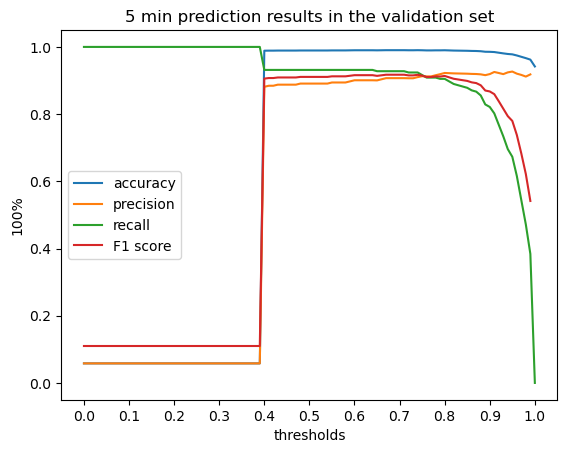

for 5 min predition, recall 0.9315589353612167 accuracy 0.9896109637488948 percision 0.8941605839416058 F1 0.9124767225325885


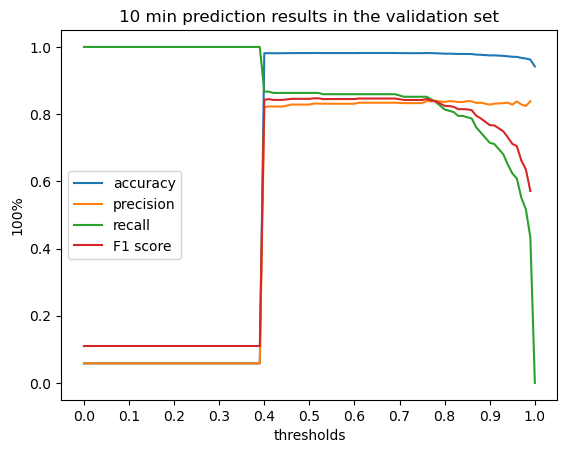

for 10 min predition, recall 0.8593155893536122 accuracy 0.9816534040671971 percision 0.8308823529411765 F1 0.8448598130841122


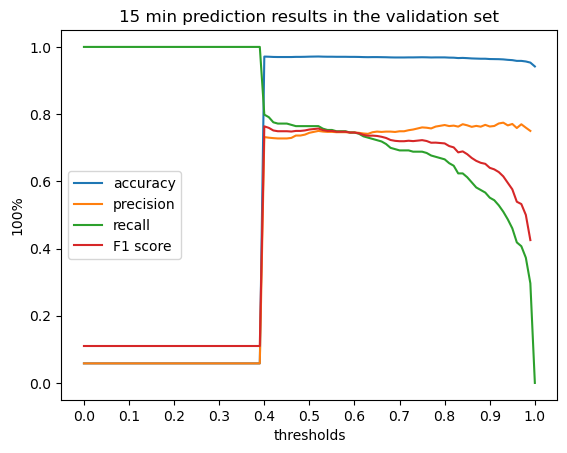

for 15 min predition, recall 0.7490494296577946 accuracy 0.9706012378426172 percision 0.7462121212121212 F1 0.747628083491461


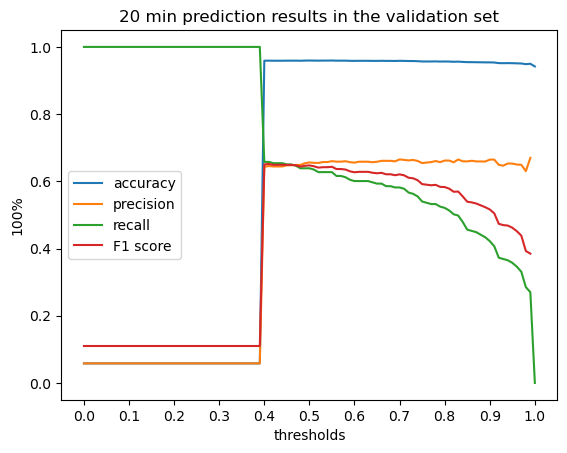

for 20 min predition, recall 0.6159695817490495 accuracy 0.9591069849690539 percision 0.6585365853658537 F1 0.6365422396856583


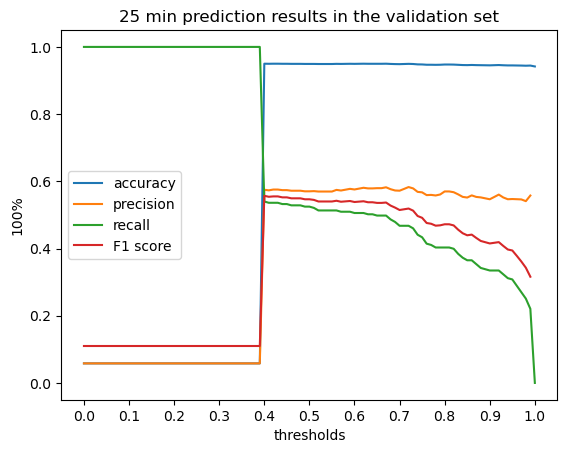

for 25 min predition, recall 0.5133079847908745 accuracy 0.9496021220159151 percision 0.574468085106383 F1 0.542168674698795


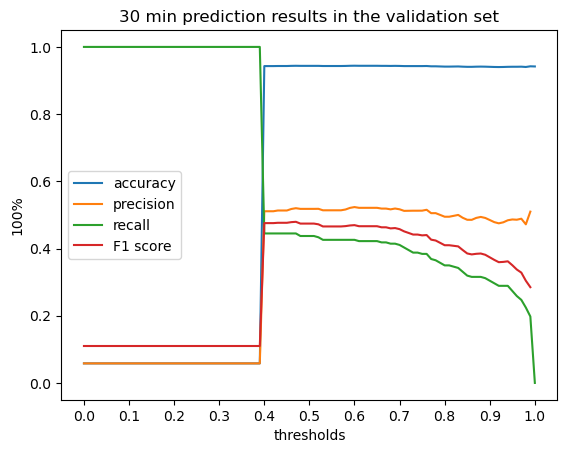

for 30 min predition, recall 0.42585551330798477 accuracy 0.9431918656056587 percision 0.5137614678899083 F1 0.4656964656964657
day_number_is 26
detected!!!!!!! [-79.31666666666666] -79.31666666666666
detected!!!!!!! [8.55] 8.55
detected!!!!!!! [-23.266666666666666] -23.266666666666666
DR 0.23076923076923078 FAR 0.9333333333333333 MTTD -31.344444444444445
SDR 1.0 SFAR 0.1 SMTTD -31.344444444444445


C:\Users\haowu\AppData\Local\Temp\ipykernel_551868\3925642866.py:19: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df_waze_link['Start time'] = pd.to_datetime(df_waze_link['Start time'], errors='coerce')
c:\Users\haowu\Anaconda3\envs\traffic\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\haowu\AppData\Local\Temp\ipykernel_551868\3925642866.py:20: FutureWarning: In a future version of pan

In [43]:
args.model_type= 'Seq2Seq'
args.link_id = '110-04482'
args.county = "TSMO"
args.upstream_range_mile = 2
args.downstream_range_mile = 1
args.dropout_prob= 0.3
args.dim_hidden = 256
args.batch_size = 256
args.lr = 0.0001
args.inc_ahead_label_min = 15
args.number_of_business_day = 260
args.num_layer_EncTrans = 2

args.model_path = 'E:/two_stage_model'
args.start_date = dt(2022, 2, 14) #dt(2022, 2, 1)
args.end_date =  dt(2023, 2, 12) #dt(2024, 1, 31)
args.start_time = 330 # 05:30:00 
args.end_time = 1260 # 21:00:00

pred, annomaly, test_resut = check_link_specific_LR_results(
    args, 
    v_or_t = 'valid', 
    min_max_avg = 'min', 
    ahead_number = 0, 
    use_filtered_Waze = False,
    compare_with_waze = False,
    plot_graph = True
)

IAD = IncidentDetectionAnalysis(args, pred, annomaly)
DR, FAR, MTTD, all_fail_to_detect_cases, all_false_postive_cases, Detected_Report_Dict, Detected_Report_Alert_Dict = IAD.check_overall_results()
print('DR', DR, 'FAR', FAR, 'MTTD', MTTD)
SDR, SFAR, SMTTD, Sall_fail_to_detect_cases, Sall_false_postive_cases, SDetected_Report_Dict, SDetected_Report_Alert_Dict = IAD.check_overall_s_results()
print('SDR', SDR, 'SFAR', SFAR, 'SMTTD', SMTTD)

Seq2Seq_G2_2_1_T_F_F_T_T_F_F_F_F_T_in_7_out_6_tg_1_cv_1_dp_0.3_hidden_256_batch_256_lr_0.0001_tf_0.5_inca_15
model path is E:/two_stage_model/model/checkpoints/TSMO/110-04482/LR/best_Seq2Seq_G2_2_1_T_F_F_T_T_F_F_F_F_T_in_7_out_6_tg_1_cv_1_dp_0.3_hidden_256_batch_256_lr_0.0001_tf_0.5_inca_15.pt
*****************************model successfully loaded*****************************
val_loss is:  [tensor(0.7498, device='cuda:0')] test_loss is:  [tensor(0.6403, device='cuda:0')]


C:\Users\haowu\AppData\Local\Temp\ipykernel_551868\3857140969.py:16: RuntimeWarning: invalid value encountered in scalar divide
  percision = np.sum(TP_mask)/(np.sum(TP_mask)+np.sum(FP_mask))


the best threshold is 0.56
4524 26 174
(4210,)
8


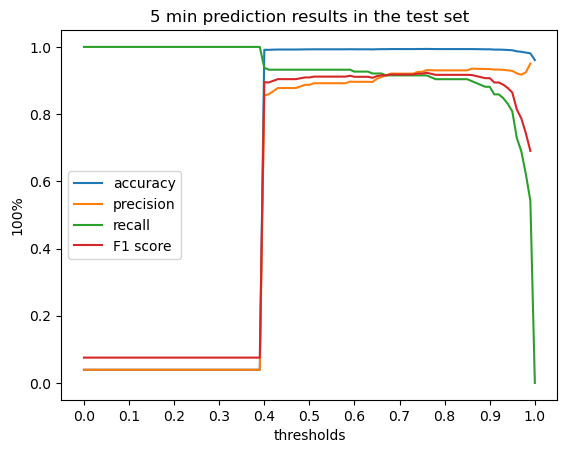

for 5 min predition, recall 0.9322033898305084 accuracy 0.9929266136162688 percision 0.8918918918918919 F1 0.9116022099447514


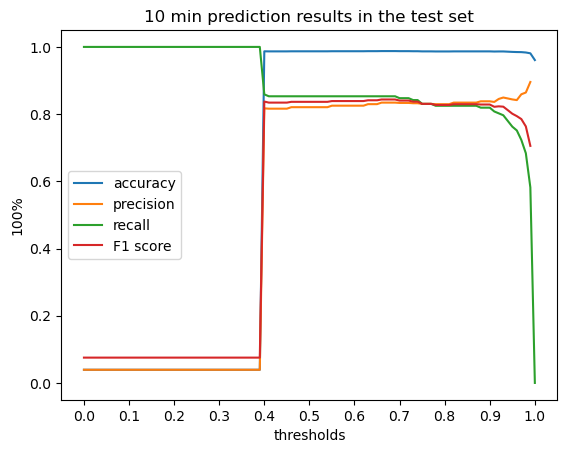

for 10 min predition, recall 0.8531073446327684 accuracy 0.9871794871794872 percision 0.825136612021858 F1 0.838888888888889


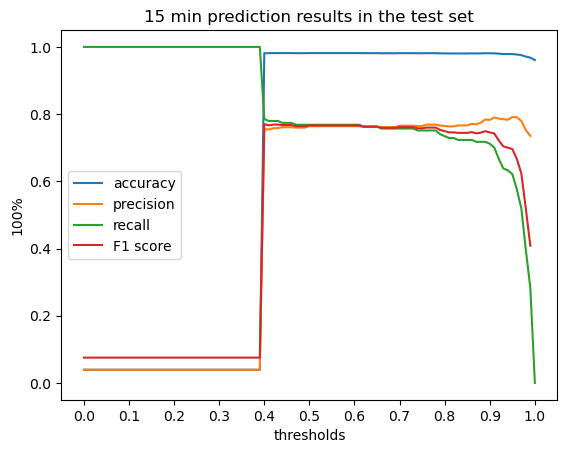

for 15 min predition, recall 0.768361581920904 accuracy 0.9816534040671971 percision 0.7640449438202247 F1 0.7661971830985914


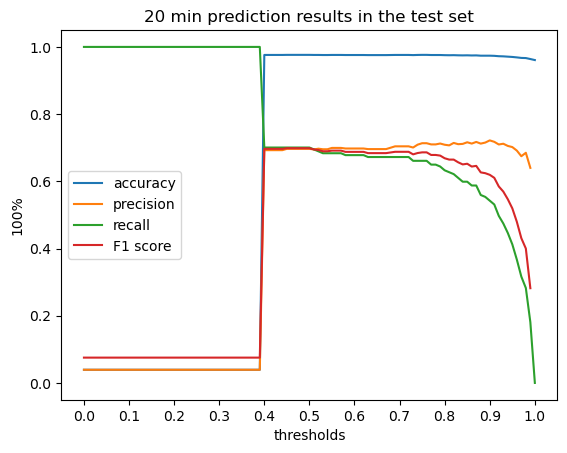

for 20 min predition, recall 0.6836158192090396 accuracy 0.9761273209549072 percision 0.6994219653179191 F1 0.6914285714285714


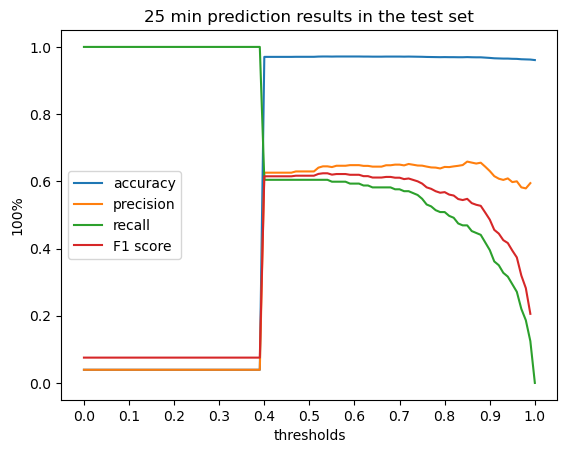

for 25 min predition, recall 0.5988700564971752 accuracy 0.9714854111405835 percision 0.6463414634146342 F1 0.6217008797653959


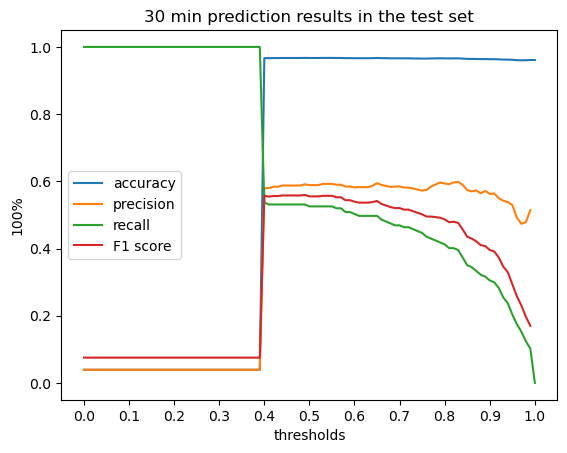

for 30 min predition, recall 0.519774011299435 accuracy 0.9670645446507515 percision 0.5897435897435898 F1 0.5525525525525525
day_number_is 26
detected!!!!!!! [-19.316666666666666, 10.683333333333334] -19.316666666666666
detected!!!!!!! [-16.216666666666665] -16.216666666666665
detected!!!!!!! [-16.45, 8.55] -16.45
detected!!!!!!! [-23.266666666666666, 46.733333333333334] -23.266666666666666
detected!!!!!!! [18.433333333333334, 58.43333333333333] 18.433333333333334
detected!!!!!!! [-18.016666666666666, 11.983333333333333] -18.016666666666666
DR 0.46153846153846156 FAR 0.6153846153846154 MTTD -12.472222222222221
SDR 1.0 SFAR 0.23076923076923078 SMTTD -12.472222222222221


C:\Users\haowu\AppData\Local\Temp\ipykernel_551868\3925642866.py:19: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df_waze_link['Start time'] = pd.to_datetime(df_waze_link['Start time'], errors='coerce')
c:\Users\haowu\Anaconda3\envs\traffic\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\haowu\AppData\Local\Temp\ipykernel_551868\3925642866.py:20: FutureWarning: In a future version of pan

In [42]:
args.model_type= 'Seq2Seq'
args.link_id = '110-04482'
args.county = "TSMO"
args.upstream_range_mile = 2
args.downstream_range_mile = 1
args.dropout_prob= 0.3
args.dim_hidden = 256
args.batch_size = 256
args.lr = 0.0001
args.inc_ahead_label_min = 15
args.number_of_business_day = 260
args.num_layer_EncTrans = 2

args.model_path = 'E:/two_stage_model'
args.start_date = dt(2022, 2, 14) #dt(2022, 2, 1)
args.end_date =  dt(2023, 2, 12) #dt(2024, 1, 31)
args.start_time = 330 # 05:30:00 
args.end_time = 1260 # 21:00:00

pred, annomaly, test_resut = check_link_specific_LR_results(
    args, 
    v_or_t = 'test', 
    min_max_avg = 'min', 
    ahead_number = 0, 
    use_filtered_Waze = False,
    compare_with_waze = False,
    plot_graph = True
)

IAD = IncidentDetectionAnalysis(args, pred, annomaly)
DR, FAR, MTTD, all_fail_to_detect_cases, all_false_postive_cases, Detected_Report_Dict, Detected_Report_Alert_Dict = IAD.check_overall_results()
print('DR', DR, 'FAR', FAR, 'MTTD', MTTD)
SDR, SFAR, SMTTD, Sall_fail_to_detect_cases, Sall_false_postive_cases, SDetected_Report_Dict, SDetected_Report_Alert_Dict = IAD.check_overall_s_results()
print('SDR', SDR, 'SFAR', SFAR, 'SMTTD', SMTTD)